Hi everyone, my name is Yohanes.
In this project, I'm going to analyze the California Housing Prices dataset, which contains housing data derived from the 1990 California census.

This dataset provides a great opportunity to explore machine learning concepts. It includes detailed information on housing characteristics in various California districts, such as the number of rooms, median income, population, and proximity to the ocean.

Although the dataset is based on older data (from 1990), it remains a popular benchmark for teaching machine learning due to its moderate size and easy-to-understand features.

The main objective of this project is to build a regression-based Machine Learning model that can predict the median house value using the available features.

The variables/features/columns of this dataset are as following,

1. **longitude**: A measure of how far west a house is; a higher value is farther west --> **useful for identifying geographical trends in housing prices**.

2. **latitude**: A measure of how far north a house is; a higher value is farther north --> **important to assess pricing trends across northern and southern regions**.

3. **housingMedianAge**: Median age of a house within a block; a lower number is a newer building --> **older areas may have different price patterns due to building conditions**.

4. **totalRooms**: Total number of rooms within a block --> **high values may indicate denser or larger housing units**.

5. **totalBedrooms**: Total number of bedrooms within a block --> **helps derive ratios like bedroom-to-room, which may influence value**.

6. **population**: Total number of people residing within a block --> **used to assess density and possible demand for housing**.

7. **households**: Total number of households, a group of people residing within a home unit, for a block --> **closely tied to population and housing occupancy**.

8. **medianIncome**: Median income for households within a block of houses *(measured in tens of thousands of US Dollars)* --> **Strong predictor of purchasing power and housing affordability**.

9. **medianHouseValue**: Median house value for households within a block *(measured in US Dollars)* --> **the value we're trying to predict using the other features**.

10. **oceanProximity**: Location of the house w.r.t *(with respect to)* ocean/sea --> **proximity to coastlines often increases housing value due to desirability**.

## I. IMPORT LIBRARIES

In [ ]:
!pip install optuna

In [ ]:
import sklearn
print("Scikit-learn version:", sklearn.__version__)

Scikit-learn version: 1.6.1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import gdown

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import RobustScaler

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

import optuna
import time
import shap
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## II. LOAD THE DATASET

In this section, I'm going to load the dataset from my personal Google Drive into the notebook.

In [ ]:
# Import the Housing Price Dataset from Google Drive
file_id = '1OoO2imBU1Tl8g76geHdk12B3tNqe5GYu'
download_url = f'https://drive.google.com/uc?id={file_id}'
output = 'housing.csv'
gdown.download(download_url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1OoO2imBU1Tl8g76geHdk12B3tNqe5GYu
To: /content/housing.csv
100%|██████████| 1.42M/1.42M [00:00<00:00, 51.7MB/s]


'housing.csv'

In [ ]:
# Load California Housing Price dataset
df = pd.read_csv("housing.csv")

# Display the first 5 rows of the housing dataset
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
# Get all column names from the dataset
col_names = df.columns

# Display column names
col_names

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [ ]:
# Check the shape and overall information of the dataset
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


(20640, 10)

In [ ]:
# Show statistical summary of numerical variables or features with 2 decimal rounding from the original dataset
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.57,2.00,-124.35,-121.80,-118.49,-118.01,-114.31
latitude,20640.0,35.63,2.14,32.54,33.93,34.26,37.71,41.95
housing_median_age,20640.0,28.64,12.59,1.00,18.00,29.00,37.00,52.00
total_rooms,20640.0,2635.76,2181.62,2.00,1447.75,2127.00,3148.00,39320.00
total_bedrooms,20433.0,537.87,421.39,1.00,296.00,435.00,647.00,6445.00
population,20640.0,1425.48,1132.46,3.00,787.00,1166.00,1725.00,35682.00
households,20640.0,499.54,382.33,1.00,280.00,409.00,605.00,6082.00
median_income,20640.0,3.87,1.90,0.50,2.56,3.53,4.74,15.00
median_house_value,20640.0,206855.82,115395.62,14999.00,119600.00,179700.00,264725.00,500001.00


## III. DATA EXPLORATION & PREPARATION

In this section, I'm going to explore and prepare the dataset with the following steps,
1. Recognize unique and any invalid values.
2. Identify and handle any duplicates and missing values.
3. Feature engineering.
4. Visualize value distributions.
5. Point out and handle any outliers.
6. Encode categorical variables/columns.

#### **1. Recognize unique and any invalid values.**

In [ ]:
# Display the number of unique values of each variable
df.nunique()

,0
longitude,844
latitude,862
housing_median_age,52
total_rooms,5926
total_bedrooms,1923
population,3888
households,1815
median_income,12928
median_house_value,3842
ocean_proximity,5


In [ ]:
# Detect and identify any invalid values in each column/variable
def detect_invalid_values(df):

    print("DETECTING INVALID VALUES.....")
    for col in df.columns:
        print(f"\nColumn: {col}")

        if pd.api.types.is_numeric_dtype(df[col]):

            # Check entries in Numeric Columns that cannot be converted to numbers
            invalid_entries = df[~df[col].apply(lambda x: pd.isna(x) or isinstance(x, (int, float)))]
            if not invalid_entries.empty:
                print('Invalid values found (example):')
                print(invalid_entries[col].value_counts().head())
            else:
                print('All values are valid (Numeric)...')

        elif pd.api.types.is_string_dtype(df[col]):

            # Check for empty strings or hidden NaN like values in Text columns
            suspicious = df[col].isin(["", " ", "n/a", "NA", "NaN", "unknown", "?"])
            if suspicious.sum() > 0:
                print(f"Found {suspicious.sum()} suspicious values (such as empty text, '?', etc.):")
                print(df[col][suspicious].value_counts())
            else:
                print('No suspicious strings found...')

        else:
            print('Special data type column (not Numeric or String ones)')


In [ ]:
detect_invalid_values(df)

DETECTING INVALID VALUES.....

Column: longitude
All values are valid (Numeric)...

Column: latitude
All values are valid (Numeric)...

Column: housing_median_age
All values are valid (Numeric)...

Column: total_rooms
All values are valid (Numeric)...

Column: total_bedrooms
All values are valid (Numeric)...

Column: population
All values are valid (Numeric)...

Column: households
All values are valid (Numeric)...

Column: median_income
All values are valid (Numeric)...

Column: median_house_value
All values are valid (Numeric)...

Column: ocean_proximity
No suspicious strings found...


#### **2. Identify and handle any duplicates and missing values.**

In [ ]:
# Display the number of duplicated values
df.duplicated().sum()

np.int64(0)

In [ ]:
# Count & display any missing values from each variable
missing_count = df.isnull().sum()
missing_percent = (missing_count / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_count,
    'Percentage (%)': missing_percent
})

print(missing_df[missing_df['Missing Values'] > 0])

# It is also possible to use "df.isnull().sum()" to identify any missing values

                Missing Values  Percentage (%)
total_bedrooms             207        1.002907


In [ ]:
# Impute and fill missing entries of total_bedrooms with median value

# 1. Create imputer object with median strategy
imputer = SimpleImputer(strategy='median')

# 2. Apply imputation only to the total_bedrooms variable
df['total_bedrooms'] = imputer.fit_transform(df[['total_bedrooms']])

In [ ]:
# 3. Check if there are still missing values after imputation
print("Number of missing values of total_bedrooms after imputation:")
print(df['total_bedrooms'].isnull().sum())

Number of missing values of total_bedrooms after imputation:
0


In [ ]:
# 4. Show the median value used to fill missing entries of total_bedrooms
median_value = df['total_bedrooms'].median()
print(f"Median value used for imputation of total_bedrooms: {median_value}")

Median value used for imputation of total_bedrooms: 435.0


#### **3. Feature engineering.**

Since there are 2 related variables/columns such as `total_rooms` and `total_bedrooms`, I'm going to create a new variable named `bedroom_ratio` as a part of feature engineering.

In [ ]:
# Create a new variable named bedroom_ratio by dividing total_bedrooms by total_rooms
df['bedroom_ratio'] = df['total_bedrooms'] / df['total_rooms']

# Check the first 5 rows to ensure the new variable is correctly created
df[['total_bedrooms', 'total_rooms', 'bedroom_ratio']].head()

,total_bedrooms,total_rooms,bedroom_ratio
0,129.0,880.0,0.146591
1,1106.0,7099.0,0.155797
2,190.0,1467.0,0.129516
3,235.0,1274.0,0.184458
4,280.0,1627.0,0.172096


#### **4. Visualize value distributions.**

In [ ]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
 10  bedroom_ratio       20640 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.7+ MB


(20640, 11)

Displaying value distribution for variable/column: longitude


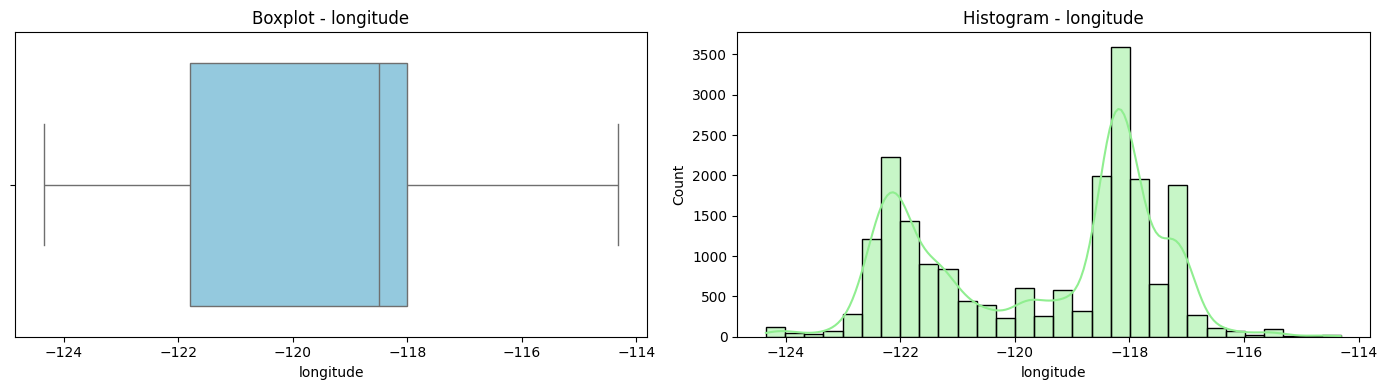

Displaying value distribution for variable/column: latitude


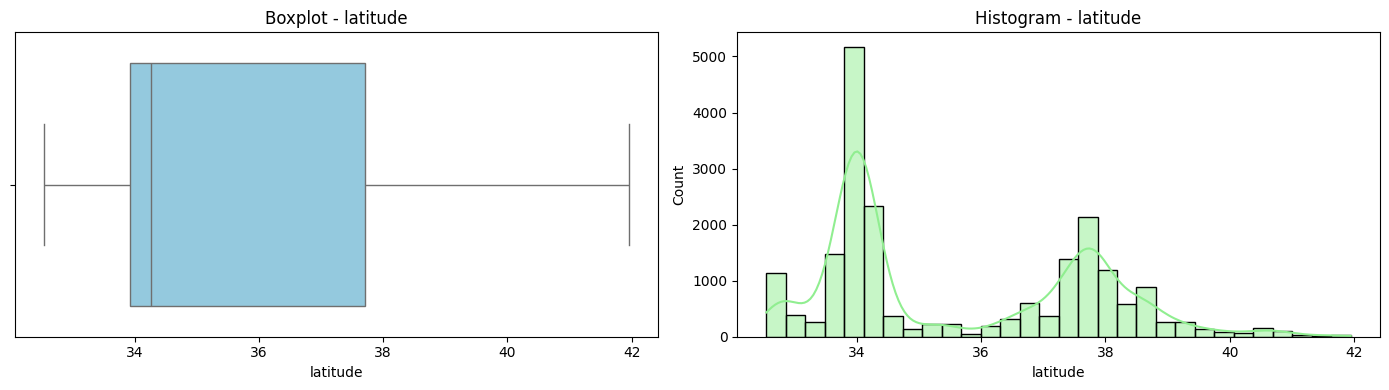

Displaying value distribution for variable/column: housing_median_age


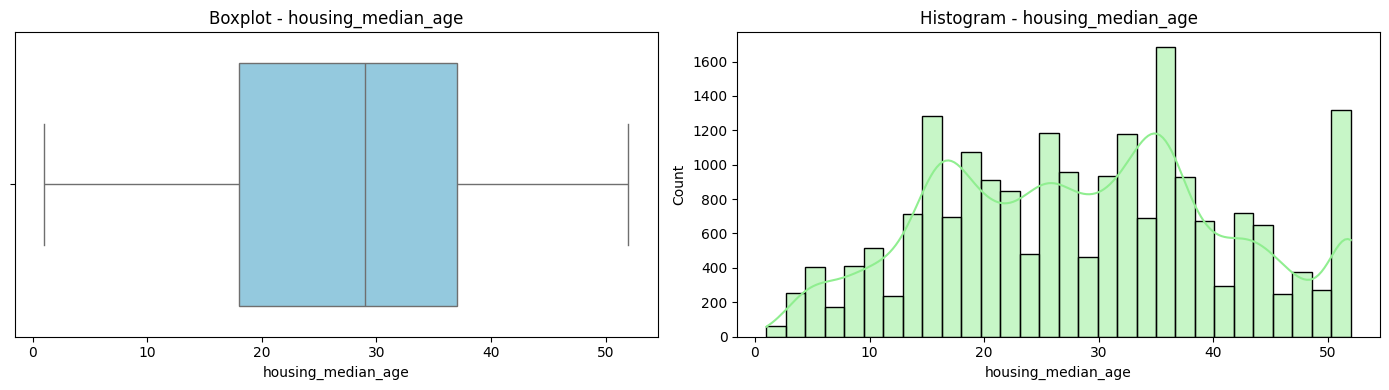

Displaying value distribution for variable/column: total_rooms


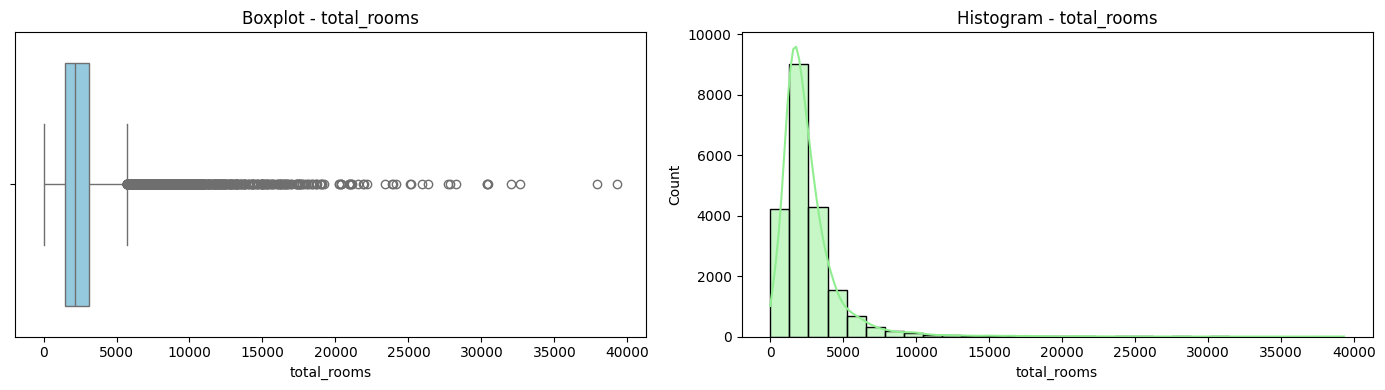

Displaying value distribution for variable/column: total_bedrooms


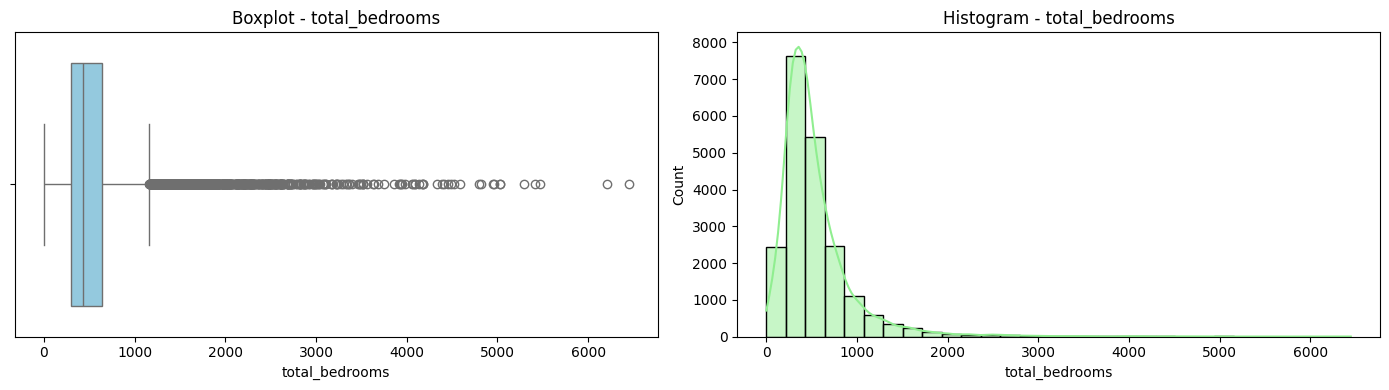

Displaying value distribution for variable/column: population


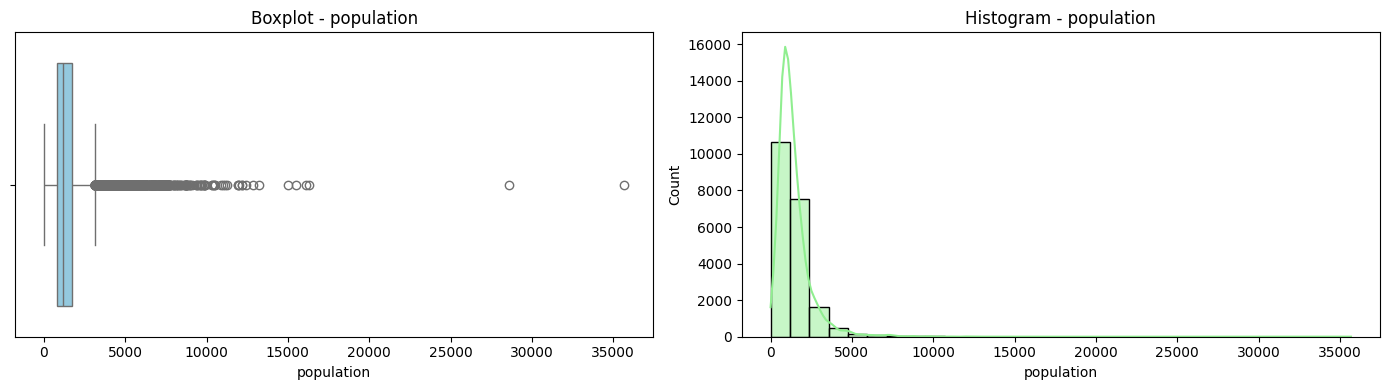

Displaying value distribution for variable/column: households


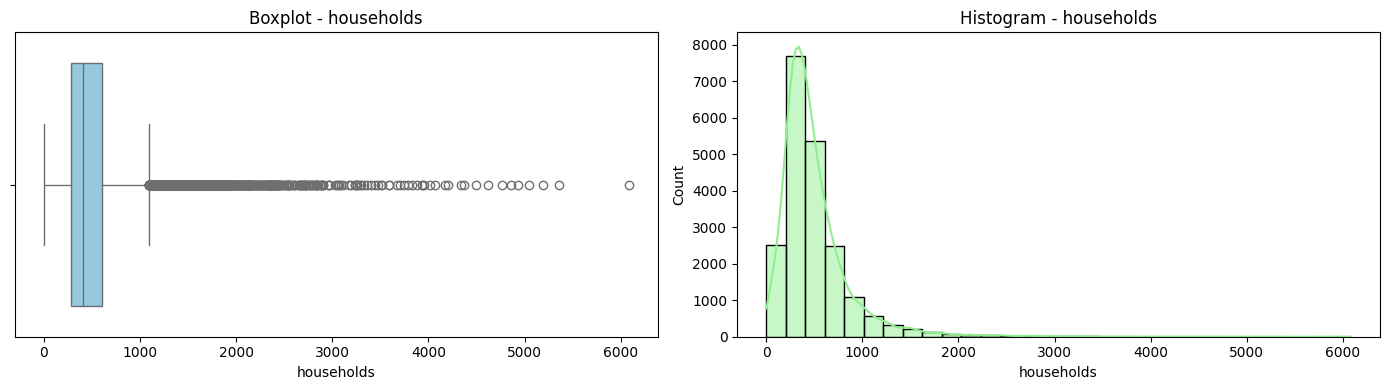

Displaying value distribution for variable/column: median_income


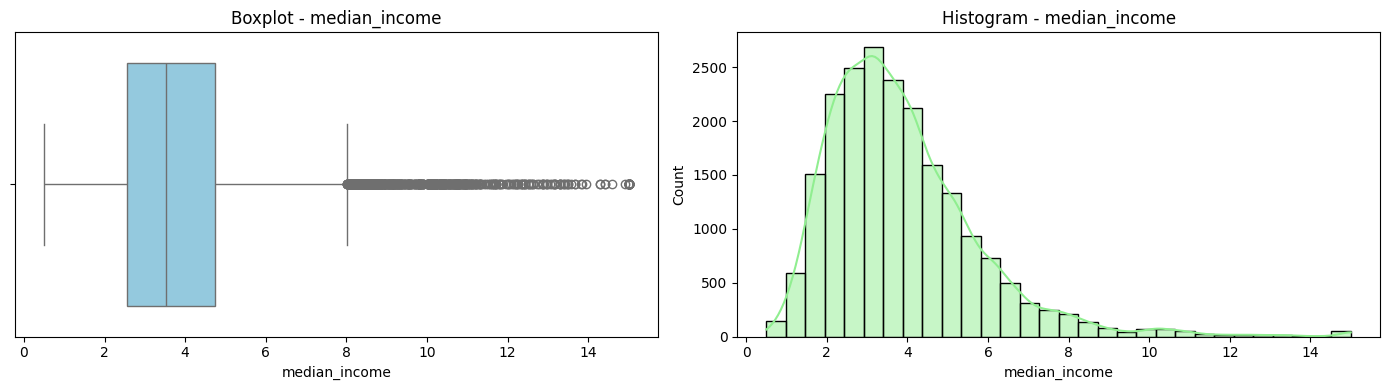

Displaying value distribution for variable/column: median_house_value


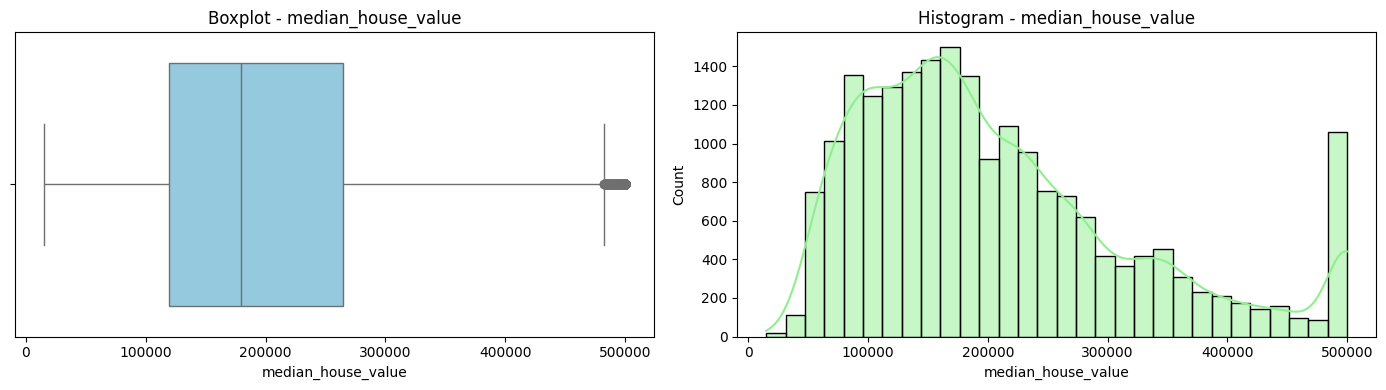

Displaying value distribution for variable/column: bedroom_ratio


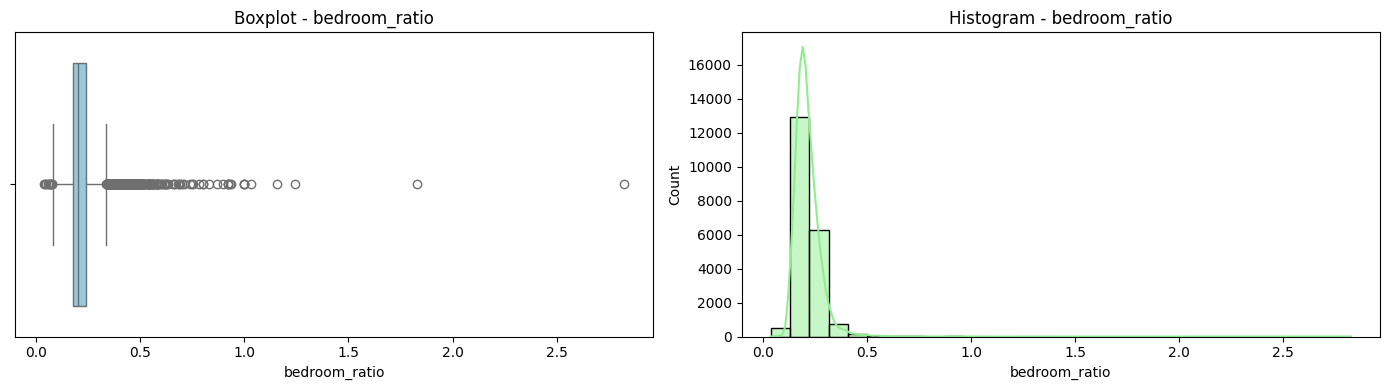

In [ ]:
# Set default plot size for numerical variables/columns of the dataset
plt.rcParams['figure.figsize'] = (12, 4)

# Store numerical variables/columns from the dataset
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Loop through each numerical variable/column and display boxplots & histplots
for col in numerical_columns:
    print(f"Displaying value distribution for variable/column: {col}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # Display the boxplots
    sns.boxplot(x=df[col], ax=axes[0], color='skyblue')
    axes[0].set_title(f'Boxplot - {col}')

    # Display the histplots
    sns.histplot(df[col], kde=True, ax=axes[1], bins=30, color='lightgreen')
    axes[1].set_title(f'Histogram - {col}')

    plt.tight_layout()
    plt.show()


/tmp/ipython-input-3978550494.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='ocean_proximity', data=df, palette='pastel')


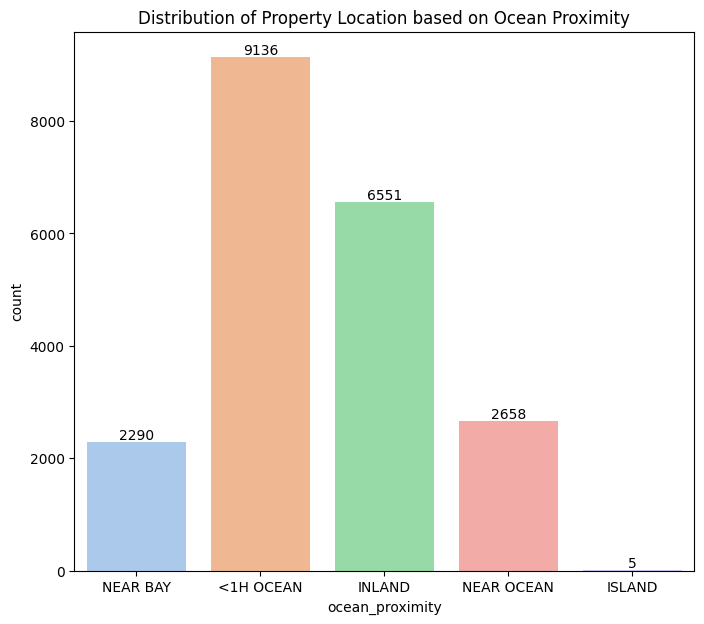

In [ ]:
# Set plot size for categorical variable of the dataset
plt.figure(figsize=(8, 7))

# Create a countplot for the 'ocean_proximity' variable
ax = sns.countplot(x='ocean_proximity', data=df, palette='pastel')

# Add value labels above each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 50,
        int(height),
        ha='center'
    )

# Add title above the plot
plt.title("Distribution of Property Location based on Ocean Proximity")
plt.show()

#### **5. Point out and handle any outliers.**

After the visualization of values distribution from the dataset, I can start the process of identifying outliers.

In [ ]:
# Select numerical variables/columns of the dataset
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Initialize a Dataframe to store outlier summary
outlier_summary = pd.DataFrame(columns=['Outlier Count', 'Outlier Percentage (%)'])

# Loop to calculate outliers per variable/column using the IQR method
for col in numerical_columns:
    Q1 = df[col].quantile(0.25)  # First quartile (25%)
    Q3 = df[col].quantile(0.75)  # Third quartile (75%)
    IQR = Q3 - Q1                # Interquartile range

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outlier values
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    # Count number and percentage of outliers
    count = len(outliers)
    percentage = (count / len(df)) * 100

    # Store the result into summary table
    outlier_summary.loc[col] = [count, round(percentage, 2)]

# Display outlier summary
print(outlier_summary)

                    Outlier Count  Outlier Percentage (%)
longitude                     0.0                    0.00
latitude                      0.0                    0.00
housing_median_age            0.0                    0.00
total_rooms                1287.0                    6.24
total_bedrooms             1306.0                    6.33
population                 1196.0                    5.79
households                 1220.0                    5.91
median_income               681.0                    3.30
median_house_value         1071.0                    5.19
bedroom_ratio               635.0                    3.08


To preserve the original dataset, I'm going to use `Winsorization` method instead of dropping the outliers.

**i. What is `Winsorization`?**

It is a statistical technique to reduce the impact of extreme outliers by replacing the most extreme values (either low or high) with less extreme percentiles.

**ii. For example**, in a 90% Winsorization, the top 5% and bottom 5% of a dataset are capped at the 95th and 5th percentile values, respectively.

**iii. Keypoints:**

a. Unlike trimming (deleting outliers), `Winsorization` retains all data points but 'clips' them.

b. It is common in machine learning, finance, and biostatistics to handle skewed data.

**iv. The goal** of this technique is to preserve data structure while making any analysis (e.g. Logistic Regressor & Random Forest) less sensitive to outliers.

The original dataset which is `df` **(after imputation)** will be kept, alternatively, the `winsorized` dataset will be named `df_winsorized`.

In [ ]:
# Copy the original dataset after imputation to a new variable
df_winsorized = df.copy()

In [ ]:
# Store all numerical variables/columns EXCEPT the target variable/column
target_column = 'median_house_value'
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_columns.remove(target_column) # Remove the target variable/column

# Winsorization using the IQR method
for col in numerical_columns:
    Q1 = df_winsorized[col].quantile(0.25)
    Q3 = df_winsorized[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Clip extreme values to lower or upper bound
    df_winsorized[col] = df_winsorized[col].clip(lower=lower_bound, upper=upper_bound)

# Show the result of winsorization process
print("Winsorization process done! The dataset is named df_winsorized.")

Winsorization process done! The dataset is named df_winsorized.


In [ ]:
print(df_winsorized[numerical_columns].describe())

          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2441.692472   
std        2.003532      2.135952           12.585558   1397.790038   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000   5698.375000   

       total_bedrooms    population    households  median_income  \
count    20640.000000  20640.000000  20640.000000   20640.000000   
mean       501.182086   1336.959012    469.020107       3.801010   
std        284.133641    765.550830    265.507540       1.657658   
min          1.000000      3.000000      1.000000       0.499900   
25%        297.00000

Below is the visualization of values distribution of numerical columns in **`df_winsorized`** without the target variable **(`median_house_value`)**.

In [ ]:
# Select numeric columns for visualization (excluding the target)
numerical_columns_winsor_visual = df_winsorized.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_columns_winsor_visual.remove('median_house_value')

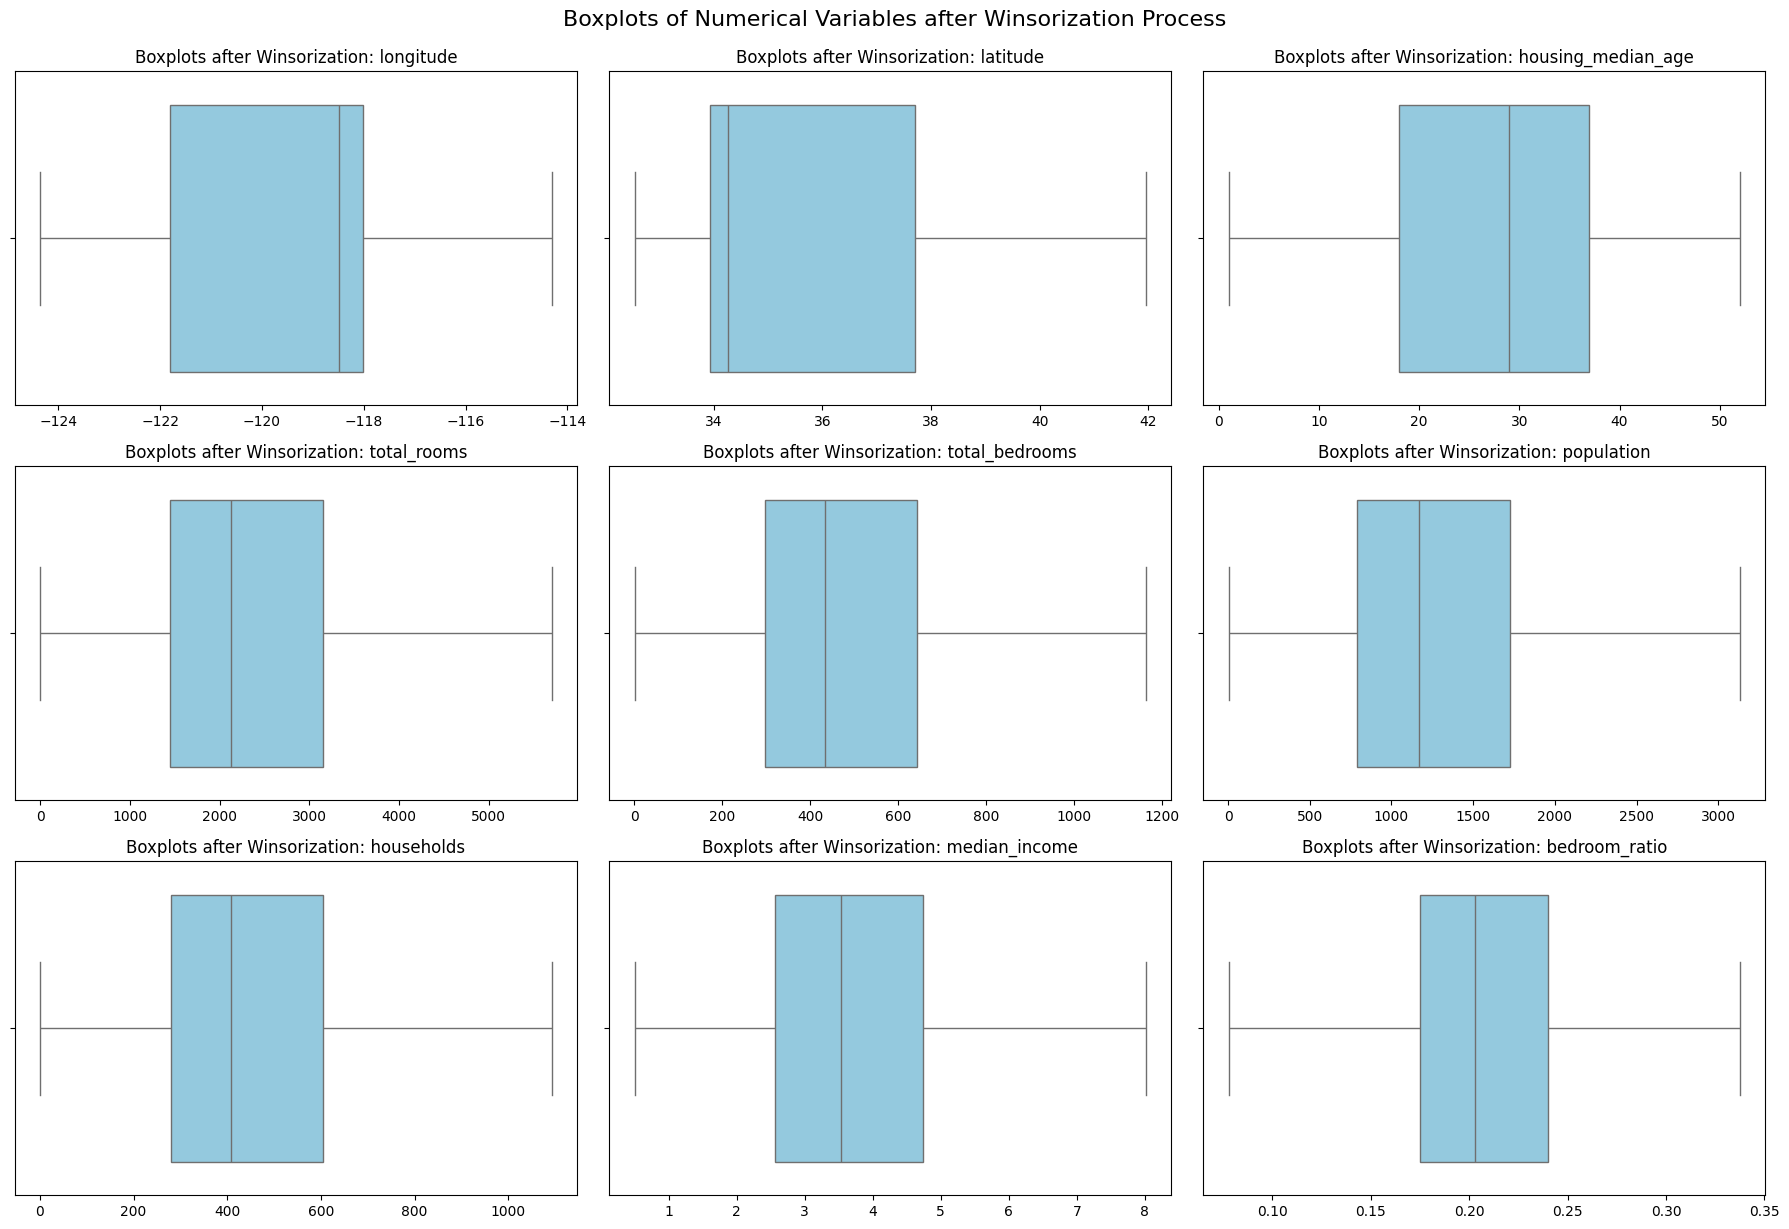

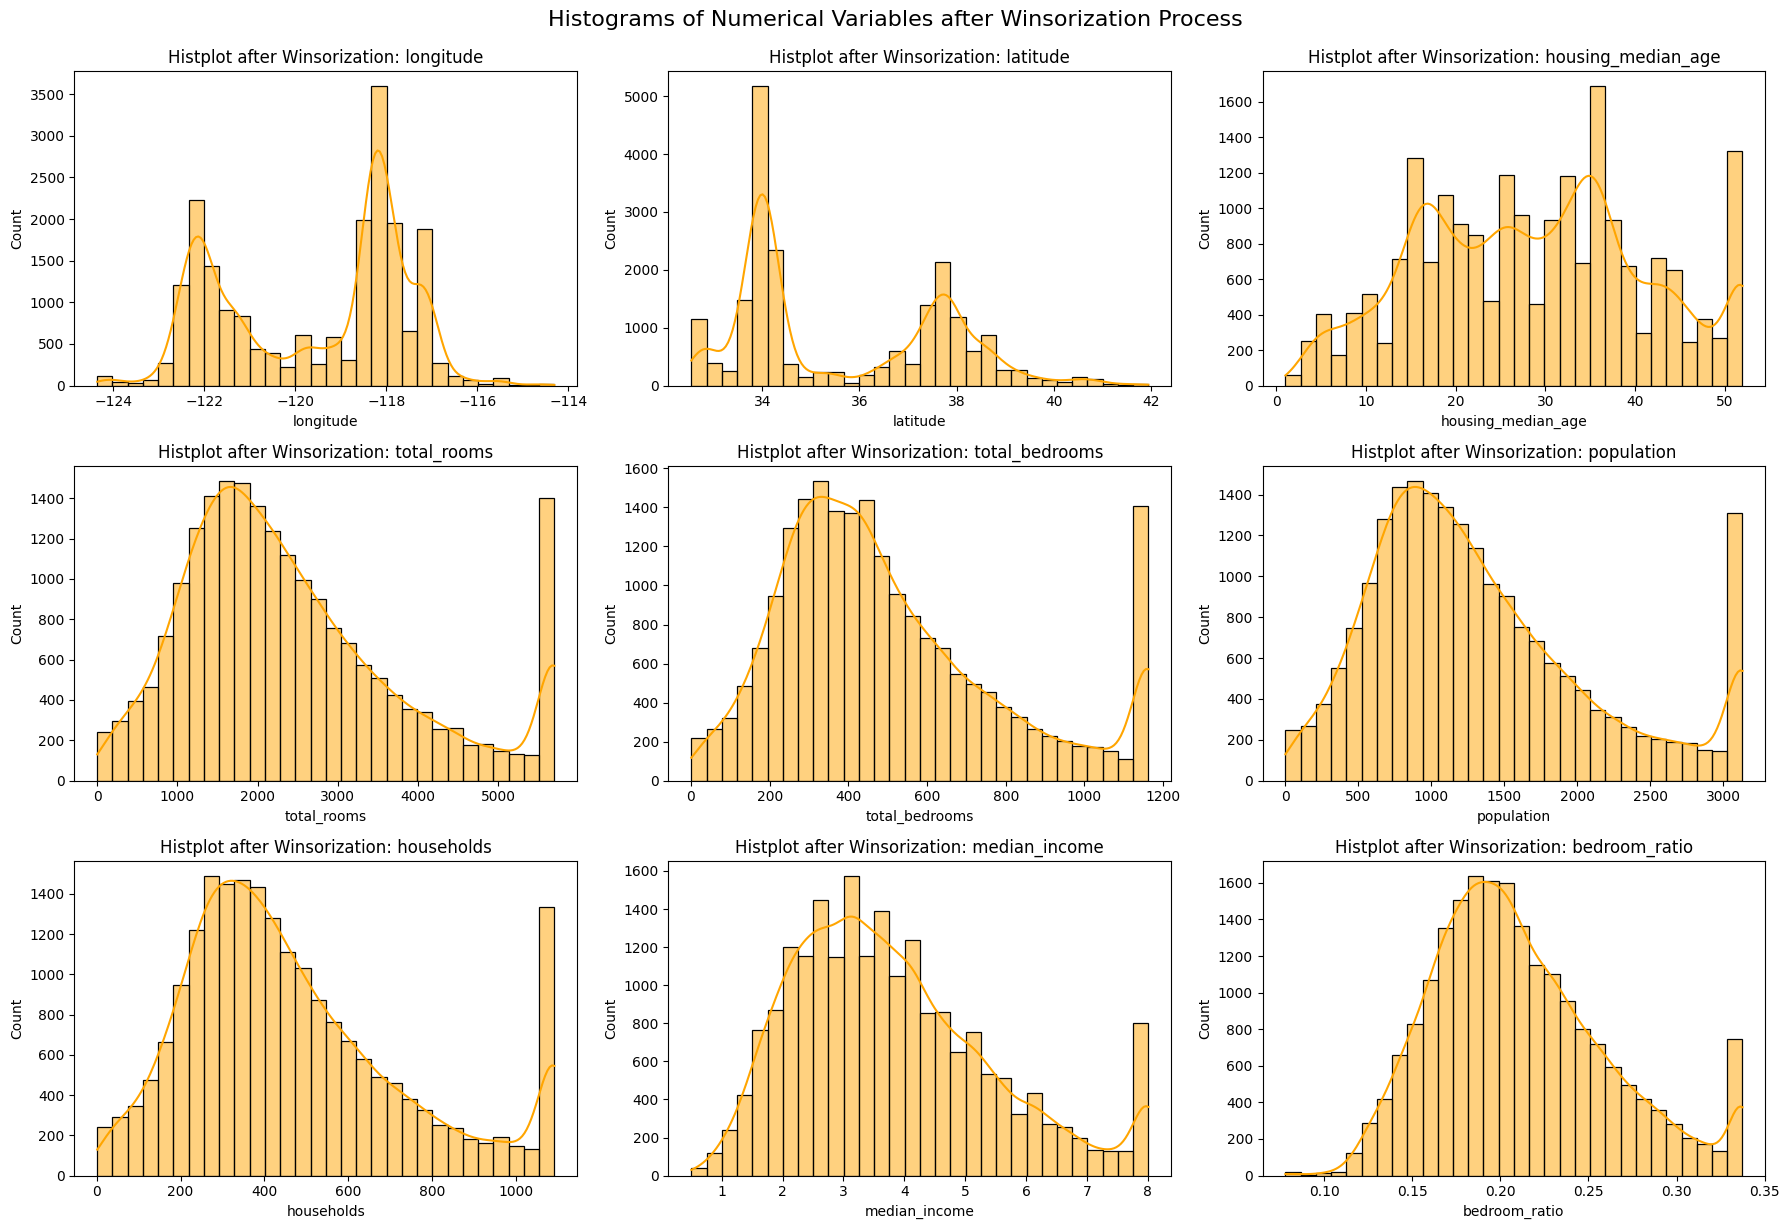

In [ ]:
# Create subplots (2 rows include boxplots & histplots)
n_cols = 3
n_rows = -(-len(numerical_columns_winsor_visual) // n_cols)

plt.figure(figsize=(n_cols * 6, n_rows * 4))

# Boxplots visualization
for i, col in enumerate(numerical_columns_winsor_visual):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=df_winsorized[col], color='skyblue')
    plt.title(f'Boxplots after Winsorization: {col}')
    plt.xlabel('')

plt.tight_layout()
plt.suptitle('Boxplots of Numerical Variables after Winsorization Process', y=1.02, fontsize=16)
plt.show()

# Histplots visualization
plt.figure(figsize=(n_cols * 6, n_rows * 4))

for i, col in enumerate(numerical_columns_winsor_visual):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df_winsorized[col], kde=True, color='orange', bins=30)
    plt.title(f'Histplot after Winsorization: {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.suptitle('Histograms of Numerical Variables after Winsorization Process', y=1.02, fontsize=16)
plt.show()

#### **6. Encode categorical variables/columns.**

Now, I want to **encode** the values of `ocean_proximity` as the dataset's only categorical variable/column. The name of the dataset after the encoding process will be **`df_encoded`**.

In [ ]:
# Copy the winsorized dataset to a new dataset for encoding process
df_encoded = df_winsorized.copy()

In [ ]:
# Perform one-hot encoding on the 'ocean_proximity' column
df_encoded = pd.get_dummies(df_encoded, columns=['ocean_proximity'], drop_first=True)

In [ ]:
# Display the result after the encoding process of 'ocean_proximity' column
print('Encoding process is done. The current dataset is saved as df_encoded.')

Encoding process is done. The current dataset is saved as df_encoded.


In [ ]:
print("The variables/columns after the encoding process are as following,")
print(df_encoded.columns.tolist())

The variables/columns after the encoding process are as following,
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'bedroom_ratio', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']


In [ ]:
df_encoded.info()
df_encoded.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20640 non-null  float64
 1   latitude                    20640 non-null  float64
 2   housing_median_age          20640 non-null  float64
 3   total_rooms                 20640 non-null  float64
 4   total_bedrooms              20640 non-null  float64
 5   population                  20640 non-null  float64
 6   households                  20640 non-null  float64
 7   median_income               20640 non-null  float64
 8   median_house_value          20640 non-null  float64
 9   bedroom_ratio               20640 non-null  float64
 10  ocean_proximity_INLAND      20640 non-null  bool   
 11  ocean_proximity_ISLAND      20640 non-null  bool   
 12  ocean_proximity_NEAR BAY    20640 non-null  bool   
 13  ocean_proximity_NEAR OCEAN  206

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,bedroom_ratio,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.000,129.0,322.0,126.0,8.013025,452600.0,0.146591,False,False,True,False
1,-122.22,37.86,21.0,5698.375,1106.0,2401.0,1092.5,8.013025,358500.0,0.155797,False,False,True,False
2,-122.24,37.85,52.0,1467.000,190.0,496.0,177.0,7.257400,352100.0,0.129516,False,False,True,False
3,-122.25,37.85,52.0,1274.000,235.0,558.0,219.0,5.643100,341300.0,0.184458,False,False,True,False
4,-122.25,37.85,52.0,1627.000,280.0,565.0,259.0,3.846200,342200.0,0.172096,False,False,True,False


#### ----- **CORRELATION MATRIX** -----

As an additional yet important step, I want to create a **`Correlation Matrix`** visualization using a **`heatmap`**.

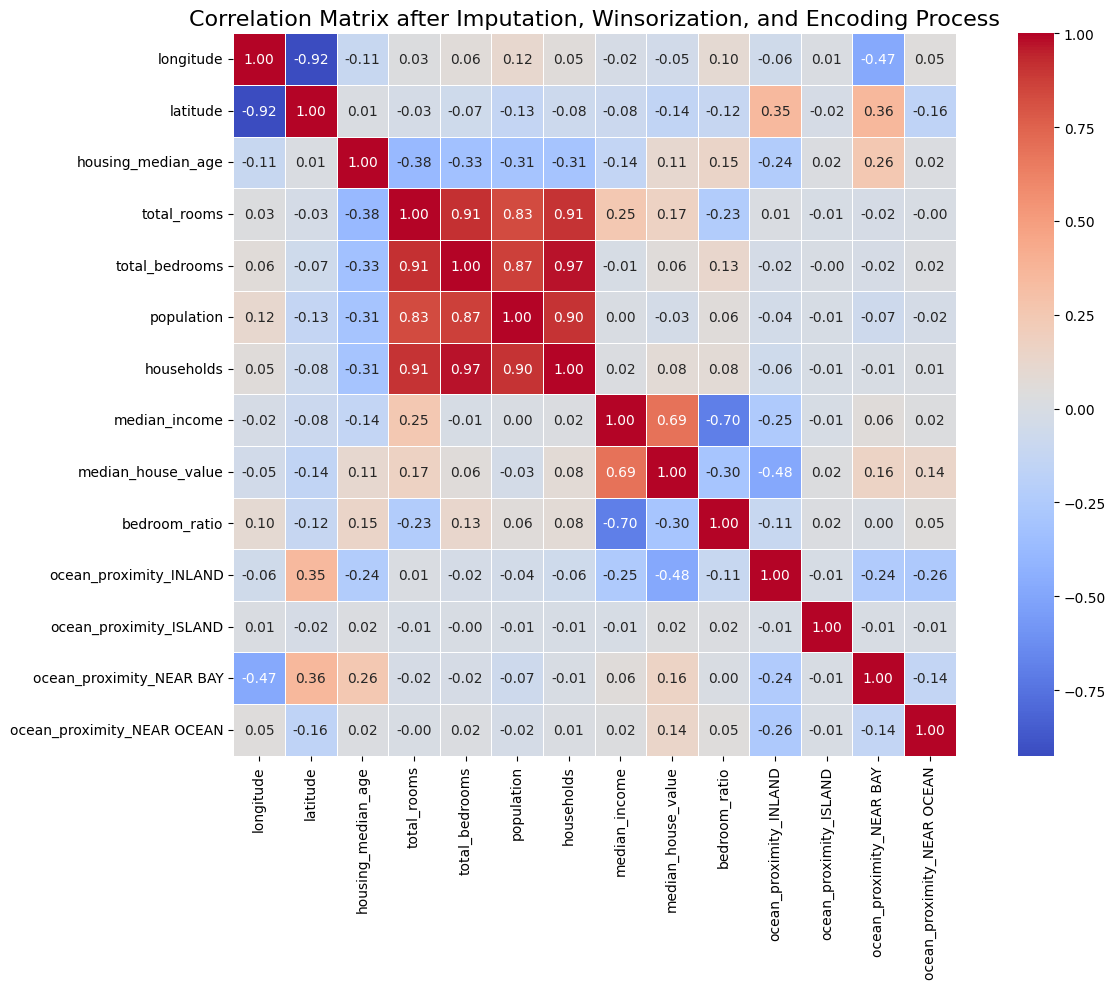

In [ ]:
# Compute correlation among all Numerical Variables after imputation, winsorization, and encoding process
correlation_matrix = df_encoded.corr(numeric_only=True)

# Display and visualize the correlation matrix as a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)

# Add title on the heatmap layout
plt.title('Correlation Matrix after Imputation, Winsorization, and Encoding Process', fontsize=16)
plt.tight_layout()
plt.show()

Based on the heatmap that Correlation Matrix visualization above, there are some insights that I want to point out,

1. `median_income` shows the strongest positive correlation (0.69) with `median_house-value`, indicating that level of income is a key factor in predicting house value.

2. `bedroom_ratio` shows a negative correlation (0.30) with `median_house-value`, suggesting that a higher proportion of `total_bedrooms` to `total_rooms` might reduce `median_house-value`.

3. Encoded categorical variables of `ocean_proximity` variations show mild coorelations with `median_house-value`, indicating location-based influence.

4. Other features like `total_rooms`, `total_bedrooms`, `population`, and `households` are strongly correlated with each other (>= 0.9), indicating **possible multicollinearity**.

## III. MODELLING PREPARATION (part 1)

### **Ridge Linear Regressor**

In this section, I will prepare the dataset and build a predictive model using **`Ridge Linear Regressor`**. The steps include:

1. Separating the dataset into features (X) and target (y).

2. Splitting the data into training and test sets **(with random_state for reproducibility)**.

3. Applying **`RobustScaler`** to scale the features and reduce the impact of outliers.

4. Tuning the model hyperparameters using **`Optuna`** for optimal performance.

5. Training the model with **`Ridge Linear Regressor`** to reduce overfitting and address multicollinearity.

6. Evaluating the model using regression metrics such as MAE, RMSE, and R² score.

#### ----- **EXPLANATION OF EVALUATION METRICS** -----

1. MAE (Mean Absolute Error)
- It is the average of the absolute differences between the predicted and actual house prices.
- How much the model's predictions deviate from the actual prices (in USD) on average.
- Example: If the MAE is USD 30,000, it means the model predicts house prices with an average error of $30,000 either higher or lower.

2.  MSE (Mean Squared Error)
- It is the average of the squared differences between predicted and actual values.
- It penalizes larger errors more heavily than smaller ones, making it useful for catching large deviations.
- Example: If the MSE is USD 2,400,000,000, this large value reflects the presence of some large prediction errors, and the squaring makes it hard to interpret in USD.

3. RMSE (Root Mean Squared Error)
- It is the square root of MSE.
- Like MSE but in the same unit as the target variable, making it easier to interpret.
- Example: If the RMSE is 50,000, it means the typical prediction error is about 50,000. It's a more interpretable version of MSE.

 4. R² (R-squared Score)
- It is the proportion of variance in the target *(housing prices)* explained by the model.
- It measures model accuracy between 0 and 1 *(or 0% to 100%)*.
- Example: If R² is 0.85, it means the model explains 85% of the variability in housing prices, which indicates a strong performance.

In [ ]:
# Create a dictionary to store various regression model results
model_results = {}

# Function to evaluate regression models
def get_regression_scores(model, X_test, y_test):
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return [mae, mse, rmse, r2]

# The function above is only run once before the 1st model training
# It doesn't need to be run on every model training session
# It allows the notebook to save model evaluation to be evaluated later

In [ ]:
# 1. Split features (X) and target variable (y)
X = df_encoded.drop(columns='median_house_value')
y = df_encoded['median_house_value']

In [ ]:
# 2. Train & Test split and use random_state
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [ ]:
# 3. Scaling using RobustScaler
# Fit only on Train dataset, transform both Train and Test datasets
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 4. Hyperparameter tuning with Optuna for Ridge Linear Regressor

# Define the Optuna objective function for tuning
def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-4, 10.0, log=True)
    model = Ridge(alpha=alpha, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mse)
    return -rmse

In [ ]:
# 5. Start the Optuna study to optimize the model
start = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=1800)
end = time.time()

print(f"Optuna tuning on Ridge Linear Regressor took: {(end - start):.2f} seconds...")

[I 2025-08-06 03:57:01,643] A new study created in memory with name: no-name-3d16dadb-ccc8-46a9-8073-51ca8a479c8c
[I 2025-08-06 03:57:01,653] Trial 0 finished with value: -69912.14989820715 and parameters: {'alpha': 0.22089292421575873}. Best is trial 0 with value: -69912.14989820715.
[I 2025-08-06 03:57:01,661] Trial 1 finished with value: -69911.22386849245 and parameters: {'alpha': 0.09639318561097626}. Best is trial 1 with value: -69911.22386849245.
[I 2025-08-06 03:57:01,669] Trial 2 finished with value: -69910.46716132811 and parameters: {'alpha': 0.00013119731777360756}. Best is trial 2 with value: -69910.46716132811.
[I 2025-08-06 03:57:01,676] Trial 3 finished with value: -69910.46855763385 and parameters: {'alpha': 0.0003046852306175296}. Best is trial 2 with value: -69910.46716132811.
[I 2025-08-06 03:57:01,700] Trial 4 finished with value: -69910.47650644359 and parameters: {'alpha': 0.0012925876011729007}. Best is trial 2 with value: -69910.46716132811.
[I 2025-08-06 03:57

Optuna tuning on Ridge Linear Regressor took: 1.05 seconds...


In [ ]:
# 6. Train Ridge Linear Regressor model using the best alpha
best_alpha = study.best_params['alpha']
ridge_linear_reg_optuna_model = Ridge(alpha=best_alpha, random_state=42)
ridge_linear_reg_optuna_model.fit(X_train_scaled, y_train)

# Ridge Linear Regressor model is now ready to use
print("Ridge Linear Regressor model training completed with alpha =", best_alpha)

Ridge Linear Regressor model training completed with alpha = 0.00010104759618099901


## IV. MODELLING EVALUATION (part 1)

In [ ]:
# 7. Evaluate Ridge Linear Regressor Model + Optuna (linear_reg_optuna_model)

# Predict on test set
y_pred = ridge_linear_reg_optuna_model.predict(X_test_scaled)

# Calculate the regression metrics
mae = mean_absolute_error(y_test, y_pred)                 # Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)                  # Mean Squared Error
rmse = np.sqrt(mse)                                       # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)                             # R-squared score

# Display the results and scores
print(f"Ridge Linear Regressor with Optuna Tuning Evaluation Metrics:")
print(f"Mean Absolute Error (MAE) : {mae:.2f}")
print(f"Mean Squared Error (MSE) : {mse:.2f}")
print(f"Root Mean Squared Error (RMSE) : {rmse:.2f}")
print(f"R-squared Score (R²) : {r2:.4f}")

# Save model evaluation results to dictionary
model_results['ridge_linear_reg_optuna_model'] = [mae, mse, rmse, r2]

Ridge Linear Regressor with Optuna Tuning Evaluation Metrics:
Mean Absolute Error (MAE) : 51130.53
Mean Squared Error (MSE) : 4887473384.78
Root Mean Squared Error (RMSE) : 69910.47
R-squared Score (R²) : 0.6270


## V. MODELLING PREPARATION (part 2)

In this section, I will build a predictive model using **`LightGBM Regressor`**. The steps include:

1. Separating the dataset into features (X) and target (y).

2. Splitting the data into training and test sets **(with random_state for reproducibility)**.

3. Applying **`RobustScaler`** to scale the features and reduce the impact of outliers.

4. Tuning the model hyperparameters using **`Optuna`** for optimal performance.

5. Training the model with **`LightGBM Regressor`**.

6. Evaluating the model using regression metrics such as MAE, RMSE, and R² score.

I also repeat the feature-target split and scaling to ensure this section is self-contained and reproducible.

In [ ]:
# 1. Split features (X) and target variable (y)
X = df_encoded.drop(columns='median_house_value')
y = df_encoded['median_house_value']

In [ ]:
# 2. Train & Test split and use random_state
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [ ]:
# 3. Scaling with RobustScaler
# Fit only on Train dataset, transform both Train and Test datasets
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 4. Hyperparameter tuning using Optuna for LightGBM Regressor

# Define the Optuna objective function for tuning
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42
    }

    model = LGBMRegressor(**params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return rmse

In [ ]:
# 5. Start the Optuna study to optimize the model
start = time.time()
study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=50, timeout=1800)
end = time.time()

print(f"Optuna tuning for LightGBM Regressor completed in {(end - start):.2f} seconds.")

[I 2025-08-06 03:57:02,893] A new study created in memory with name: no-name-457dc0b3-6dc5-4133-91bc-d7de932629f3


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:03,974] Trial 0 finished with value: 46544.54476528774 and parameters: {'n_estimators': 287, 'max_depth': 8, 'learning_rate': 0.22977697393242044, 'num_leaves': 52, 'subsample': 0.5527132299104296, 'colsample_bytree': 0.6226628850112814}. Best is trial 0 with value: 46544.54476528774.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:05,248] Trial 1 finished with value: 45273.93225149482 and parameters: {'n_estimators': 273, 'max_depth': 9, 'learning_rate': 0.07281941746480408, 'num_leaves': 105, 'subsample': 0.5932077691020408, 'colsample_bytree': 0.9265651058848983}. Best is trial 1 with value: 45273.93225149482.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:05,725] Trial 2 finished with value: 46794.537381037575 and parameters: {'n_estimators': 69, 'max_depth': 12, 'learning_rate': 0.16581231728788337, 'num_leaves': 139, 'subsample': 0.8294191057060891, 'colsample_bytree': 0.9762577185703343}. Best is trial 1 with value: 45273.93225149482.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:06,066] Trial 3 finished with value: 48753.78639079072 and parameters: {'n_estimators': 131, 'max_depth': 6, 'learning_rate': 0.0678163213188411, 'num_leaves': 69, 'subsample': 0.6563538633435764, 'colsample_bytree': 0.5471014419026452}. Best is trial 1 with value: 45273.93225149482.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:07,661] Trial 4 finished with value: 45473.76992623073 and parameters: {'n_estimators': 204, 'max_depth': 11, 'learning_rate': 0.08256879781001744, 'num_leaves': 92, 'subsample': 0.7789014122937311, 'colsample_bytree': 0.9503971352491284}. Best is trial 1 with value: 45273.93225149482.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:08,826] Trial 5 finished with value: 45565.33697659416 and parameters: {'n_estimators': 211, 'max_depth': 10, 'learning_rate': 0.05890205810116507, 'num_leaves': 65, 'subsample': 0.9392803608863363, 'colsample_bytree': 0.7044890004287727}. Best is trial 1 with value: 45273.93225149482.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:09,182] Trial 6 finished with value: 49931.8518882783 and parameters: {'n_estimators': 216, 'max_depth': 4, 'learning_rate': 0.0856860763563969, 'num_leaves': 67, 'subsample': 0.5418487262426115, 'colsample_bytree': 0.6914967322253815}. Best is trial 1 with value: 45273.93225149482.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:09,638] Trial 7 finished with value: 47041.384247318085 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.2766958907046944, 'num_leaves': 33, 'subsample': 0.9533524337285373, 'colsample_bytree': 0.5021050701009331}. Best is trial 1 with value: 45273.93225149482.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:10,564] Trial 8 finished with value: 46831.01944507696 and parameters: {'n_estimators': 209, 'max_depth': 11, 'learning_rate': 0.23379021103243572, 'num_leaves': 98, 'subsample': 0.5113095607035574, 'colsample_bytree': 0.8531918574483222}. Best is trial 1 with value: 45273.93225149482.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:11,023] Trial 9 finished with value: 45843.551672970374 and parameters: {'n_estimators': 236, 'max_depth': 5, 'learning_rate': 0.2699145095351611, 'num_leaves': 36, 'subsample': 0.571207057621575, 'colsample_bytree': 0.9723533190732769}. Best is trial 1 with value: 45273.93225149482.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:12,756] Trial 10 finished with value: 51360.09477751474 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.01017766483688251, 'num_leaves': 124, 'subsample': 0.6731286804462928, 'colsample_bytree': 0.8360069908017411}. Best is trial 1 with value: 45273.93225149482.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:13,440] Trial 11 finished with value: 46214.776814504025 and parameters: {'n_estimators': 148, 'max_depth': 9, 'learning_rate': 0.12351868590016928, 'num_leaves': 103, 'subsample': 0.7911760336072953, 'colsample_bytree': 0.8510160226787288}. Best is trial 1 with value: 45273.93225149482.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:14,846] Trial 12 finished with value: 46271.0479704119 and parameters: {'n_estimators': 265, 'max_depth': 12, 'learning_rate': 0.15037609250679723, 'num_leaves': 114, 'subsample': 0.7029806122557263, 'colsample_bytree': 0.9194428652396763}. Best is trial 1 with value: 45273.93225149482.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:15,603] Trial 13 finished with value: 54094.2366382258 and parameters: {'n_estimators': 176, 'max_depth': 7, 'learning_rate': 0.014982089404006742, 'num_leaves': 84, 'subsample': 0.8596790978109159, 'colsample_bytree': 0.7768799398301346}. Best is trial 1 with value: 45273.93225149482.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:16,616] Trial 14 finished with value: 46200.37018571306 and parameters: {'n_estimators': 175, 'max_depth': 10, 'learning_rate': 0.10802482390737705, 'num_leaves': 150, 'subsample': 0.7302706550310074, 'colsample_bytree': 0.9105855559942928}. Best is trial 1 with value: 45273.93225149482.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:17,308] Trial 15 finished with value: 47625.30342280425 and parameters: {'n_estimators': 123, 'max_depth': 9, 'learning_rate': 0.04921472688624882, 'num_leaves': 88, 'subsample': 0.6171330015330182, 'colsample_bytree': 0.9990265711307844}. Best is trial 1 with value: 45273.93225149482.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:17,477] Trial 16 finished with value: 54384.77045428793 and parameters: {'n_estimators': 82, 'max_depth': 3, 'learning_rate': 0.16539937752114509, 'num_leaves': 123, 'subsample': 0.7667507517607088, 'colsample_bytree': 0.9035625414581084}. Best is trial 1 with value: 45273.93225149482.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:18,583] Trial 17 finished with value: 45230.57899967793 and parameters: {'n_estimators': 269, 'max_depth': 11, 'learning_rate': 0.11945052590751631, 'num_leaves': 82, 'subsample': 0.8612874662253598, 'colsample_bytree': 0.7825546598723849}. Best is trial 17 with value: 45230.57899967793.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:19,680] Trial 18 finished with value: 45697.03297049741 and parameters: {'n_estimators': 276, 'max_depth': 7, 'learning_rate': 0.12995197767559113, 'num_leaves': 78, 'subsample': 0.8881298417648413, 'colsample_bytree': 0.7787218801966108}. Best is trial 17 with value: 45230.57899967793.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:21,270] Trial 19 finished with value: 46019.22620692707 and parameters: {'n_estimators': 251, 'max_depth': 9, 'learning_rate': 0.19841381263065022, 'num_leaves': 110, 'subsample': 0.9182197017006362, 'colsample_bytree': 0.704604621306281}. Best is trial 17 with value: 45230.57899967793.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:22,252] Trial 20 finished with value: 46603.29803013537 and parameters: {'n_estimators': 232, 'max_depth': 11, 'learning_rate': 0.038347776506813445, 'num_leaves': 46, 'subsample': 0.9999260432577395, 'colsample_bytree': 0.6263883239771908}. Best is trial 17 with value: 45230.57899967793.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:23,222] Trial 21 finished with value: 45247.5149354171 and parameters: {'n_estimators': 195, 'max_depth': 11, 'learning_rate': 0.09473448859224301, 'num_leaves': 94, 'subsample': 0.8118544592147185, 'colsample_bytree': 0.8147143904109619}. Best is trial 17 with value: 45230.57899967793.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:24,017] Trial 22 finished with value: 45427.344219776045 and parameters: {'n_estimators': 178, 'max_depth': 12, 'learning_rate': 0.09992339295313593, 'num_leaves': 76, 'subsample': 0.8363930123314417, 'colsample_bytree': 0.8038635021227494}. Best is trial 17 with value: 45230.57899967793.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:25,201] Trial 23 finished with value: 45660.21747176569 and parameters: {'n_estimators': 264, 'max_depth': 10, 'learning_rate': 0.1265055081874558, 'num_leaves': 105, 'subsample': 0.8006482773562176, 'colsample_bytree': 0.737354674492572}. Best is trial 17 with value: 45230.57899967793.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:26,712] Trial 24 finished with value: 46482.6378795336 and parameters: {'n_estimators': 296, 'max_depth': 11, 'learning_rate': 0.1459371477386729, 'num_leaves': 126, 'subsample': 0.6243125157982723, 'colsample_bytree': 0.8709943127818403}. Best is trial 17 with value: 45230.57899967793.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:27,207] Trial 25 finished with value: 46844.28794950091 and parameters: {'n_estimators': 237, 'max_depth': 9, 'learning_rate': 0.09923780119115994, 'num_leaves': 20, 'subsample': 0.7258044780160646, 'colsample_bytree': 0.7948848546697119}. Best is trial 17 with value: 45230.57899967793.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:27,700] Trial 26 finished with value: 46139.39867058015 and parameters: {'n_estimators': 98, 'max_depth': 11, 'learning_rate': 0.1906407533976861, 'num_leaves': 94, 'subsample': 0.8795463150789617, 'colsample_bytree': 0.7438652684553619}. Best is trial 17 with value: 45230.57899967793.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training fro

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:28,711] Trial 27 finished with value: 47294.38216604195 and parameters: {'n_estimators': 191, 'max_depth': 8, 'learning_rate': 0.038533021829586865, 'num_leaves': 116, 'subsample': 0.8215535803923101, 'colsample_bytree': 0.8188611576716145}. Best is trial 17 with value: 45230.57899967793.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:29,484] Trial 28 finished with value: 46148.06810862208 and parameters: {'n_estimators': 145, 'max_depth': 12, 'learning_rate': 0.07831508747333628, 'num_leaves': 79, 'subsample': 0.9020690315210771, 'colsample_bytree': 0.8936328155002479}. Best is trial 17 with value: 45230.57899967793.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:30,340] Trial 29 finished with value: 45165.20334058289 and parameters: {'n_estimators': 273, 'max_depth': 8, 'learning_rate': 0.1120423048683481, 'num_leaves': 59, 'subsample': 0.5936801684384562, 'colsample_bytree': 0.6536415897579385}. Best is trial 29 with value: 45165.20334058289.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:30,981] Trial 30 finished with value: 46036.85941075103 and parameters: {'n_estimators': 285, 'max_depth': 6, 'learning_rate': 0.2022797582128373, 'num_leaves': 55, 'subsample': 0.7406572068809485, 'colsample_bytree': 0.6316471347891159}. Best is trial 29 with value: 45165.20334058289.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:31,762] Trial 31 finished with value: 45697.25668077198 and parameters: {'n_estimators': 273, 'max_depth': 7, 'learning_rate': 0.10836111430883008, 'num_leaves': 56, 'subsample': 0.5859749744506627, 'colsample_bytree': 0.5943723921884395}. Best is trial 29 with value: 45165.20334058289.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:32,160] Trial 32 finished with value: 47878.33659795265 and parameters: {'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.1405758564704895, 'num_leaves': 99, 'subsample': 0.6028935476791901, 'colsample_bytree': 0.6811527409235083}. Best is trial 29 with value: 45165.20334058289.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:33,503] Trial 33 finished with value: 45184.17499565865 and parameters: {'n_estimators': 255, 'max_depth': 9, 'learning_rate': 0.06894989909570697, 'num_leaves': 61, 'subsample': 0.644300412230209, 'colsample_bytree': 0.6660146275320369}. Best is trial 29 with value: 45165.20334058289.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:34,560] Trial 34 finished with value: 45106.349794148664 and parameters: {'n_estimators': 254, 'max_depth': 10, 'learning_rate': 0.11807286045636772, 'num_leaves': 45, 'subsample': 0.6536793108673992, 'colsample_bytree': 0.6667771116824647}. Best is trial 34 with value: 45106.349794148664.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:35,298] Trial 35 finished with value: 45523.34112980814 and parameters: {'n_estimators': 249, 'max_depth': 9, 'learning_rate': 0.11636712051245812, 'num_leaves': 47, 'subsample': 0.6499350036121574, 'colsample_bytree': 0.6576940540077372}. Best is trial 34 with value: 45106.349794148664.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:36,334] Trial 36 finished with value: 45483.51738438326 and parameters: {'n_estimators': 223, 'max_depth': 10, 'learning_rate': 0.062049776572980817, 'num_leaves': 62, 'subsample': 0.6951199778090389, 'colsample_bytree': 0.5777133959443668}. Best is trial 34 with value: 45106.349794148664.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:37,297] Trial 37 finished with value: 44941.195729980784 and parameters: {'n_estimators': 281, 'max_depth': 8, 'learning_rate': 0.17845872211550826, 'num_leaves': 38, 'subsample': 0.5496466491210686, 'colsample_bytree': 0.6695295861771585}. Best is trial 37 with value: 44941.195729980784.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:38,265] Trial 38 finished with value: 45886.531111925455 and parameters: {'n_estimators': 290, 'max_depth': 6, 'learning_rate': 0.17452587577194598, 'num_leaves': 36, 'subsample': 0.5341924477071508, 'colsample_bytree': 0.6632734413736434}. Best is trial 37 with value: 44941.195729980784.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:38,809] Trial 39 finished with value: 45893.16421357663 and parameters: {'n_estimators': 253, 'max_depth': 8, 'learning_rate': 0.22151038118977226, 'num_leaves': 26, 'subsample': 0.5631251245818081, 'colsample_bytree': 0.5990421098515696}. Best is trial 37 with value: 44941.195729980784.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:39,444] Trial 40 finished with value: 45684.439431125524 and parameters: {'n_estimators': 257, 'max_depth': 7, 'learning_rate': 0.17262922538937128, 'num_leaves': 45, 'subsample': 0.5015273935631624, 'colsample_bytree': 0.5582863020976074}. Best is trial 37 with value: 44941.195729980784.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:40,359] Trial 41 finished with value: 45686.12705848546 and parameters: {'n_estimators': 282, 'max_depth': 10, 'learning_rate': 0.13494155598009483, 'num_leaves': 63, 'subsample': 0.6503214125529, 'colsample_bytree': 0.6572113076091319}. Best is trial 37 with value: 44941.195729980784.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:41,086] Trial 42 finished with value: 45338.53130151389 and parameters: {'n_estimators': 267, 'max_depth': 9, 'learning_rate': 0.08549139413127482, 'num_leaves': 41, 'subsample': 0.546848777370686, 'colsample_bytree': 0.718960495747573}. Best is trial 37 with value: 44941.195729980784.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:41,870] Trial 43 finished with value: 45574.76853579292 and parameters: {'n_estimators': 241, 'max_depth': 8, 'learning_rate': 0.16089150714294387, 'num_leaves': 71, 'subsample': 0.6271071900271431, 'colsample_bytree': 0.6436445877135569}. Best is trial 37 with value: 44941.195729980784.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:42,641] Trial 44 finished with value: 45546.92469473224 and parameters: {'n_estimators': 222, 'max_depth': 10, 'learning_rate': 0.0718220745178496, 'num_leaves': 58, 'subsample': 0.587135706026196, 'colsample_bytree': 0.6903044866460327}. Best is trial 37 with value: 44941.195729980784.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:43,263] Trial 45 finished with value: 45317.94203453567 and parameters: {'n_estimators': 278, 'max_depth': 8, 'learning_rate': 0.1857460018079605, 'num_leaves': 30, 'subsample': 0.6770328048510209, 'colsample_bytree': 0.7638362356834464}. Best is trial 37 with value: 44941.195729980784.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:44,022] Trial 46 finished with value: 45587.73525813155 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.11633208440729964, 'num_leaves': 49, 'subsample': 0.6357569054108806, 'colsample_bytree': 0.5172192755918011}. Best is trial 37 with value: 44941.195729980784.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:45,161] Trial 47 finished with value: 46965.34066249358 and parameters: {'n_estimators': 266, 'max_depth': 10, 'learning_rate': 0.2596430465118892, 'num_leaves': 71, 'subsample': 0.5710923041984085, 'colsample_bytree': 0.7255798193771805}. Best is trial 37 with value: 44941.195729980784.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:46,108] Trial 48 finished with value: 45582.43156184808 and parameters: {'n_estimators': 289, 'max_depth': 7, 'learning_rate': 0.15467983029542265, 'num_leaves': 39, 'subsample': 0.524272907848542, 'colsample_bytree': 0.6150279892814032}. Best is trial 37 with value: 44941.195729980784.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-06 03:57:46,888] Trial 49 finished with value: 48991.51064306017 and parameters: {'n_estimators': 243, 'max_depth': 5, 'learning_rate': 0.05443735532093308, 'num_leaves': 52, 'subsample': 0.6753704508852519, 'colsample_bytree': 0.6823783550038693}. Best is trial 37 with value: 44941.195729980784.


Optuna tuning for LightGBM Regressor completed in 44.00 seconds.


In [ ]:
# 6. Train LightGBM Regressor model with the best parameters
best_lgb_params = study_lgb.best_params
lightgbm_optuna_model = LGBMRegressor(**best_lgb_params)
lightgbm_optuna_model.fit(X_train_scaled, y_train)

print("LightGBM model training completed with best parameters:", best_lgb_params)
print("LightGBM Regressor model training completed.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

 ## VI. MODELLING EVALUATION (part 2)

In [ ]:
# 7. Evaluate LightGBM Regressor Model + Optuna (lightgbm_optuna_model)

# Predict on test set
y_pred = lightgbm_optuna_model.predict(X_test_scaled)

# Calculate the regression metrics
mae = mean_absolute_error(y_test, y_pred)         # Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)          # Mean Squared Error
rmse = np.sqrt(mse)                               # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)                     # R-squared score

# Display the results and scores
print("LightGBM Regressor with Optuna Tuning Evaluation Metrics:")
print(f"Mean Absolute Error (MAE) : {mae:.2f}")
print(f"Mean Squared Error (MSE) : {mse:.2f}")
print(f"Root Mean Squared Error (RMSE) : {rmse:.2f}")
print(f"R-squared Score (R²) : {r2:.4f}")

# Save evaluation results to model_results dictionary
model_results['lightgbm_optuna_model'] = [mae, mse, rmse, r2]

LightGBM Regressor with Optuna Tuning Evaluation Metrics:
Mean Absolute Error (MAE) : 30571.10
Mean Squared Error (MSE) : 2093464027.35
Root Mean Squared Error (RMSE) : 45754.39
R-squared Score (R²) : 0.8402


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## VII. MODELLING PREPARATION (part 3)

In this section, I will build a predictive model using the **`Random Forest Regressor`**. The steps include:

1. Separating the dataset into features (X) and target (y).

2. Splitting the data into training and test sets **(with random_state for reproducibility)**.

3. Applying **`RobustScaler`** to scale the features and reduce the impact of outliers.

4. Tuning the model hyperparameters using **`Optuna`** for optimal performance.

5. Training the model with **`Random Forest Regressor`**.

6. Evaluating the model using regression metrics such as MAE, RMSE, and R² score.

I also repeat the feature-target split and scaling to ensure this section is self-contained and reproducible.

In [ ]:
# 1. Split features (X) and target variable (y)
X = df_encoded.drop(columns='median_house_value')
y = df_encoded['median_house_value']

In [ ]:
# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [ ]:
# 3. Scaling using RobustScaler
# Fit only on Train dataset, transform both Train and Test datasets
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 4. Hyperparameter tuning using Optuna for Random Forest

# Define the Optuna objective function for tuning
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return rmse

In [ ]:
# 5. Start the Optuna study to optimize the model
start = time.time()

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=50)

end = time.time()
print(f"Optuna tuning on Random Forest Regressor completed in: {(end - start):.2f} seconds.")
print("Best hyperparameters:", study_rf.best_params)

[I 2025-08-06 03:57:47,810] A new study created in memory with name: no-name-11bf88e6-7e0b-4708-9648-193e18b61d8a
[I 2025-08-06 03:57:52,466] Trial 0 finished with value: 55732.96770032415 and parameters: {'n_estimators': 203, 'max_depth': 11, 'max_features': 'log2'}. Best is trial 0 with value: 55732.96770032415.
[I 2025-08-06 03:58:03,530] Trial 1 finished with value: 55061.89883299027 and parameters: {'n_estimators': 59, 'max_depth': 10, 'max_features': None}. Best is trial 1 with value: 55061.89883299027.
[I 2025-08-06 03:58:17,861] Trial 2 finished with value: 55680.706055292394 and parameters: {'n_estimators': 292, 'max_depth': 11, 'max_features': 'sqrt'}. Best is trial 1 with value: 55061.89883299027.
[I 2025-08-06 03:58:20,324] Trial 3 finished with value: 70831.65239070138 and parameters: {'n_estimators': 140, 'max_depth': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 55061.89883299027.
[I 2025-08-06 03:58:55,532] Trial 4 finished with value: 53490.05983109709 and pa

Optuna tuning on Random Forest Regressor completed in: 1084.39 seconds.
Best hyperparameters: {'n_estimators': 229, 'max_depth': 20, 'max_features': None}


In [ ]:
# 6. Train Random Forest Regressor model with the best parameters
best_rf_params = study_rf.best_params

random_forest_optuna_model = RandomForestRegressor(
    **best_rf_params,
    random_state=42,
    n_jobs=-1
)
random_forest_optuna_model.fit(X_train_scaled, y_train)

print("Random Forest Regressor model training completed.")

Random Forest Regressor model training completed.


## VIII. MODELLING EVALUATION (part 3)

In [ ]:
# 7. Evaluate the trained Random Forest Regressor + Optuna model (random_forest_optuna_model)

# Predict on test set
y_pred = random_forest_optuna_model.predict(X_test_scaled)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display the evaluation results
print("Random Forest Regressor + Optuna Tuning Evaluation Metrics:")
print(f"Mean Absolute Error (MAE) : {mae:.2f}")
print(f"Mean Squared Error (MSE) : {mse:.2f}")
print(f"Root Mean Squared Error (RMSE) : {rmse:.2f}")
print(f"R-squared Score (R²) : {r2:.4f}")

# Save results to dictionary
model_results['random_forest_optuna_model'] = [mae, mse, rmse, r2]

Random Forest Regressor + Optuna Tuning Evaluation Metrics:
Mean Absolute Error (MAE) : 32515.42
Mean Squared Error (MSE) : 2511391084.80
Root Mean Squared Error (RMSE) : 50113.78
R-squared Score (R²) : 0.8084


## IX. MODELLING PREPARATION (part 4)

In this section, I will build a predictive model using the **`XGBoost Regressor`**. The steps include:

1. Separating the dataset into features (X) and target (y).

2. Splitting the data into training and test sets **(with random_state for reproducibility)**.

3. Applying **`RobustScaler`** to scale the features and reduce the impact of outliers.

4. Tuning the model hyperparameters using **`Optuna`** for optimal performance.

5. Training the model with **`XGBoost Regressor`**.

6. Evaluating the model using regression metrics such as MAE, RMSE, and R² score.

I also repeat the feature-target split and scaling to ensure this section is self-contained and reproducible.

In [ ]:
# 1. Separate features (X) and target variable (y)
X = df_encoded.drop(columns='median_house_value')
y = df_encoded['median_house_value']

In [ ]:
# 2. Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [ ]:
# 3. Scale the data using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 4. Hyperparameter tuning using Optuna for XGBoost

# Define the Optuna objective function for tuning
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42
    }

    model = XGBRegressor(**params, n_jobs=-1)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

In [ ]:
# 5. Run Optuna tuning process for XGBoost
start = time.time()
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=50)
end = time.time()

print(f"Optuna tuning on XGBoost Regressor completed in: {(end - start):.2f} seconds.")
print("Best hyperparameters:", study_xgb.best_params)

[I 2025-08-06 04:16:24,071] A new study created in memory with name: no-name-1052bd7e-ff27-4e00-a36e-6d07d8518370
[I 2025-08-06 04:16:26,495] Trial 0 finished with value: 48169.39038314279 and parameters: {'n_estimators': 247, 'max_depth': 5, 'learning_rate': 0.15377342518497022, 'subsample': 0.9870125839402168, 'colsample_bytree': 0.7659247726653686, 'gamma': 0.9444863407662729, 'reg_alpha': 0.21683547649249513, 'reg_lambda': 0.07163544063396865}. Best is trial 0 with value: 48169.39038314279.
[I 2025-08-06 04:16:27,071] Trial 1 finished with value: 47149.37471161866 and parameters: {'n_estimators': 163, 'max_depth': 6, 'learning_rate': 0.11091572822278552, 'subsample': 0.6935242551166098, 'colsample_bytree': 0.8614504242215417, 'gamma': 1.1949667623625397, 'reg_alpha': 2.4956313501379555, 'reg_lambda': 2.4794900160320954}. Best is trial 1 with value: 47149.37471161866.
[I 2025-08-06 04:16:32,632] Trial 2 finished with value: 47735.78868940013 and parameters: {'n_estimators': 193, 'ma

Optuna tuning on XGBoost Regressor completed in: 158.82 seconds.
Best hyperparameters: {'n_estimators': 241, 'max_depth': 9, 'learning_rate': 0.06660496781000208, 'subsample': 0.7729782562075679, 'colsample_bytree': 0.7193863803822448, 'gamma': 2.0319842405562696, 'reg_alpha': 1.0955200328524815, 'reg_lambda': 2.597233150298077}


In [ ]:
# 6. Train XGBoost Regressor model with the best hyperparameters
best_xgb_params = study_xgb.best_params
xgb_optuna_model = XGBRegressor(**best_xgb_params, n_jobs=-1)
xgb_optuna_model.fit(X_train_scaled, y_train)

print("XGBoost Regressor model training completed.")

XGBoost Regressor model training completed.


## X. MODELLING EVALUATION (part 4)

In [ ]:
# 7. Evaluate the trained XGBoost Regressor + Optuna model (xgb_optuna_model)

# Predict on test set
y_pred = xgb_optuna_model.predict(X_test_scaled)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display the evaluation results
print("XGBoost Regressor + Optuna Tuning Evaluation Metrics:")
print(f"Mean Absolute Error (MAE) : {mae:.2f}")
print(f"Mean Squared Error (MSE) : {mse:.2f}")
print(f"Root Mean Squared Error (RMSE) : {rmse:.2f}")
print(f"R-squared Score (R²) : {r2:.4f}")

# Save model evaluation results to dictionary
model_results['xgb_optuna_model'] = [mae, mse, rmse, r2]

XGBoost Regressor + Optuna Tuning Evaluation Metrics:
Mean Absolute Error (MAE) : 30063.12
Mean Squared Error (MSE) : 2150599144.92
Root Mean Squared Error (RMSE) : 46374.55
R-squared Score (R²) : 0.8359


## XI. MODEL COMPARISON & SELECTION

After training 4 kinds of model with the following evaluation metrics, I can find out which one is the best model to predict housing price in California.

1. **Ridge Linear Regressor Model + Optuna** `(ridge_linear_reg_optuna_model)`.

Evaluation Metrics:

a. Mean Absolute Error (MAE): 51130.53

b. Mean Squared Error (MSE): 4887473384.78

c. Root Mean Squared Error (RMSE): 69910.47

d. R-squared Score (R²): 0.6270

2.  **LightGBM Regressor Model + Optuna** `(lightgbm_optuna_model)`.

Evaluation Metrics:

a. Mean Absolute Error (MAE): 30571.10

b. Mean Squared Error (MSE): 2093464027.35

c. Root Mean Squared Error (RMSE): 45754.39

d. R-squared Score (R²): 0.8402

3. **Random Forest Regressor Model + Optuna** `(random_forest_optuna_model)`.

Evaluation Metrics:

a. Mean Absolute Error (MAE): 32515.42

b. Mean Squared Error (MSE): 2511391084.80

c. Root Mean Squared Error (RMSE): 50113.78

d. R-squared Score (R²): 0.8084

4. **XGBoost Regressor Model + Optuna** `(xgb_optuna_model)`.

Evaluation Metrics:

a. Mean Absolute Error (MAE): 30063.12

b. Mean Squared Error (MSE): 2150599144.92

c. Root Mean Squared Error (RMSE): 46374.55

d. R-squared Score (R²): 0.8359

Therefore, based on those evaluation metrics, the best model to predict housing price is the **`LightGBM Regressor with Optuna Tuning`** model **`(lightgbm_optuna_model)`**. Let me visualize the evaluation metrics with a grouped barchart.

In [ ]:
# 1. Create a dictionary of model names
models = {
    "Ridge Linear Reg. + Optuna": ridge_linear_reg_optuna_model,
    "LightGBM Reg. + Optuna": lightgbm_optuna_model,
    "Random Forest Reg. + Optuna": random_forest_optuna_model,
    "XGBoost Reg. + Optuna": xgb_optuna_model
}

In [ ]:
# 2. The function to evaluate models and collect evaluation metrics automatically
model_results = {}
for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    model_results[model_name] = {"MAE": mae, "RMSE": rmse, "R²": r2}

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
# 3a. Convert evaluation metrics into DataFrame for tabular display
df_results = pd.DataFrame(model_results).T

# 3b. Transpose for grouped-bar-chart plotting grouped by metrics
df_transposed = df_results.T

In [ ]:
# 4. The function to create and plot grouped bar chart by evaluation metrics
def plot_grouped_by_metric(df):
    metrics = df.index.tolist()  # ["MAE", "RMSE", "R²"]
    model_names = df.columns.tolist()
    x = np.arange(len(model_names))  # for MAE and RMSE only
    width = 0.18
    colors = ['skyblue', 'red', 'green']

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# 4a. Subplot 1 for MAE and RMSE
    for i, metric in enumerate(["MAE", "RMSE"]):
        values = df.loc[metric]
        bars = ax1.bar(x + i * width, values, width, label=metric, color=colors[i])
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2, height + 1000, f"{height:.0f}", ha='center', fontsize=9)

    ax1.set_ylabel("Error Score")
    ax1.set_title("Grouped Bar Chart for MAE and RMSE Metrics")
    ax1.set_xticks(x + width / 2)
    ax1.set_xticklabels(model_names, rotation=15, ha='right')
    ax1.legend()
    ax1.grid(axis='y', linestyle='--', alpha=0.5)

# 4b. Subplot 2 for R²
    values = df.loc["R²"]
    bars = ax2.bar(x, values, width, label="R²", color=colors[2])
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", ha='center', fontsize=9)

    ax2.set_ylabel("R² Score")
    ax2.set_title("Grouped Bar Chart for R² Score Metrics")
    ax2.set_xticks(x)
    ax2.set_xticklabels(model_names, rotation=15, ha='right')
    ax2.set_ylim(0, 1.1)
    ax2.legend()
    ax2.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()

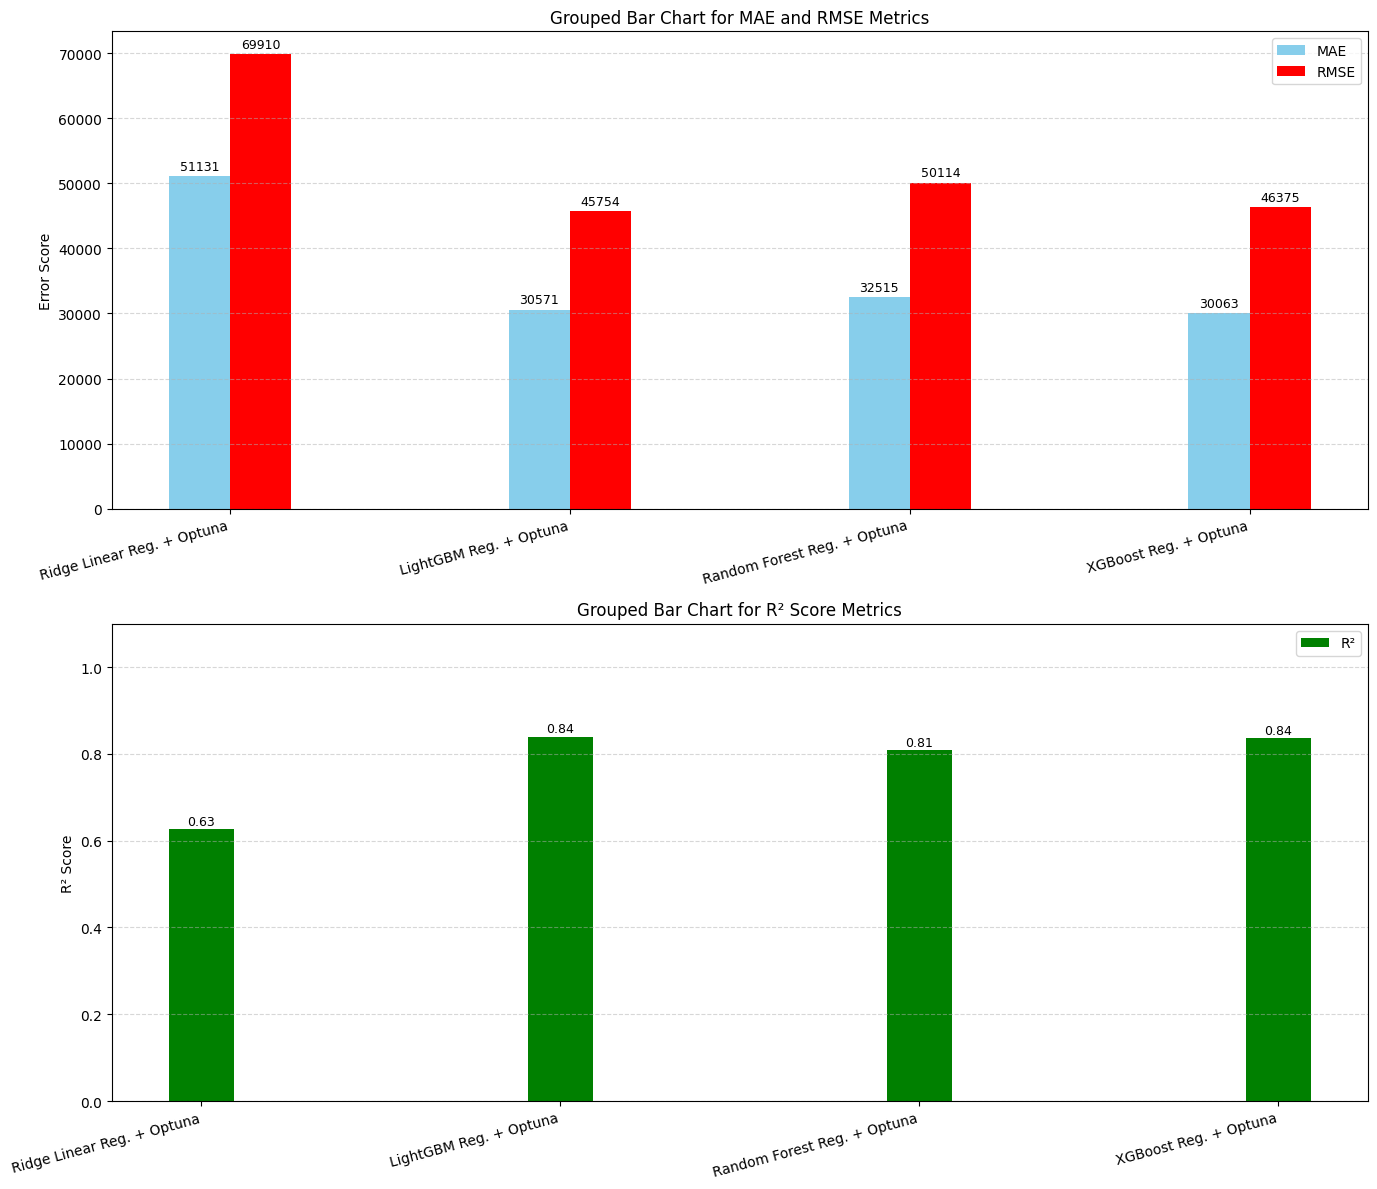

In [ ]:
# 5a. Execute the visualization function of grouped bar chart
plot_grouped_by_metric(df_transposed)

In [ ]:
# 5b. Execute the visualization function of DataFrame with tabular display
display(df_results.round(2))

,MAE,RMSE,R²
Ridge Linear Reg. + Optuna,51130.53,69910.47,0.63
LightGBM Reg. + Optuna,30571.10,45754.39,0.84
Random Forest Reg. + Optuna,32515.42,50113.78,0.81
XGBoost Reg. + Optuna,30063.12,46374.55,0.84


**`Mean Squared Error (MSE)`** is not included in the grouped bar chart because the figures are too high or disproportionately large compared to MAE, RMSE, and R². This would make the chart to be distorted and difficult to interpret visually.

Since **`RMSE`** is simply the square root of **`MSE`**, it already conveys the same information in a more interpretable way, using the same units as the target variable **(e.g. housing price in USD)**. Thus, including both **`MSE`** and **`RMSE`** would be redundant.

To keep the visualization clean, consistent, and easy to compare, I decided to only include **`MAE`**, **`RMSE`**, and **`R²`**.

## XII. SHAP VALUE ANALYSIS

I want to include a **`SHAP (SHapley Additive exPlanations)`** value analysis, because it can helps us understand how **each feature/variable/column** contributes to the model's prediction rates.

It assigns each feature/variable/column a value representing its impact on a specific prediction.

By analyzing **`SHAP`** values, we can:
- Identify the most influential features in the model.
- Ensure the model makes decisions based on reasonable patterns (not false correlations).
- Improve transparency and trust in machine learning model predictions.

In [ ]:
# 1. Create SHAP explainer for the LightGBM Regressor with Optuna tuning model
explainer = shap.Explainer(lightgbm_optuna_model)

# 2. Calculate SHAP values on the Scaled Test Dataset
shap_values = explainer(X_test_scaled)

# 3. Retrieve feature names from the original (Non-scaled) X_test
feature_names = X_test.columns

# 4. Create summary dataframe
shap_summary = pd.DataFrame({
    "Feature/Variable/Column": feature_names,
    "Mean SHAP Value": np.abs(shap_values.values).mean(axis=0).round(2)
}).sort_values(by="Mean SHAP Value", ascending=False)

# 5. Display the top 10 most important features
display(shap_summary.head(10))

,Feature/Variable/Column,Mean SHAP Value
7,median_income,33381.28
1,latitude,30936.70
0,longitude,30800.01
9,ocean_proximity_INLAND,23398.50
5,population,15157.70
8,bedroom_ratio,11958.70
3,total_rooms,8695.20
4,total_bedrooms,5631.58
2,housing_median_age,5472.42
6,households,4174.12


The **`Mean SHAP Value`** represents the average absolute impact of each feature on the model's prediction across all test samples.

In this case, higher values indicate that a feature has a stronger influence on predicting house prices in California. Here's what we can infer:

1. **`median_income (33,381.28)`**.
This is the most influential feature in the model. Higher median household income in a district is strongly associated with higher predicted house prices.

2. **`latitude (30,936.70)`** and **`longitude (30,800.01)`**.
Geographical location plays a major role in housing prices. Areas located in certain regions typically have higher or lower prices.

3. **`ocean_proximity_INLAND (23,398.50)`**.
Whether a property is located inland significantly affects the predicted price. Inland locations generally have lower prices than coastal areas, so this variable has a strong impact.

4. **population (15,157.70)`**.
The number of people in a district affects price predictions, possibly due to supply-demand factors or urban density effects.

5. **`bedroom_ratio (11,958.70)`**.
The ratio of bedrooms to total rooms helps assess living space quality and influences house price predictions accordingly.

6. **`total_rooms (8,695.20)`** and **`total_bedrooms (5,631.58)`**.
These raw counts affect the estimated size of properties, which in turn influence their valuation.

7. **`housing_median_age (5,472.42)`**.
Older or newer houses contribute differently to price predictions depending on location and maintenance expectations.

8. **`households (4,174.12)`**
The number of households in a district has some impact, potentially linked to neighborhood density or housing supply.

There are no ideal range for Mean SHAP values. They only focus on the order of importance of features/variables/columns and their proportions.

## XIII. ADDITIONAL PERFORMANCE EVALUATION

### A. Error Analysis

An **`Error (Residual) Analysis`** is a critical step after evaluating model performance metrics like MAE, RMSE, and R².

A residual is the difference between the actual value (y_test) and the predicted value (y_pred).

With **`Error (Residual) Analysis`**, we can:

- Check whether prediction errors are randomly distributed or show systematic patterns.

- Ensure there is no systematic bias, such as the model consistently underestimating or overestimating for high-income or high-value homes.

- Detect overfitting, especially if residuals are low in training but high in test data.

- Assess whether the residuals follow an approximately normal distribution, which is important for statistical assumptions and fair model interpretation.

In conclusion, **`Error (Residual) Analysis`** helps determine if a model is balanced and fair, not just numerically accurate.

Residual Summary Statistics:
count      4128.00
mean       -819.62
std       46372.93
min     -238352.00
25%      -21809.48
50%       -4573.95
75%       14138.92
max      351057.23
Name: median_house_value, dtype: float64


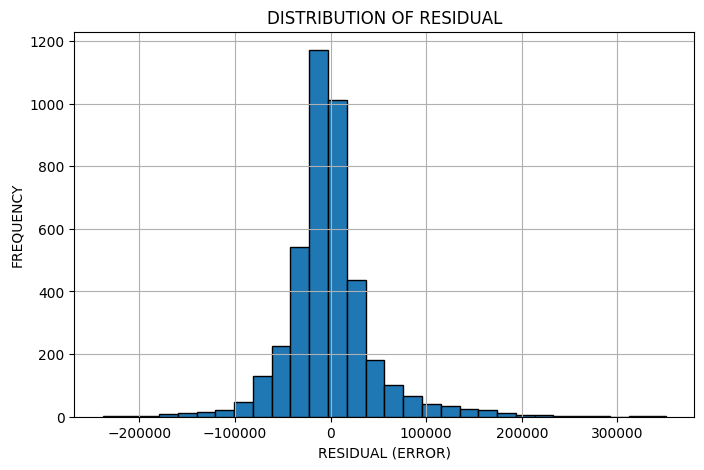

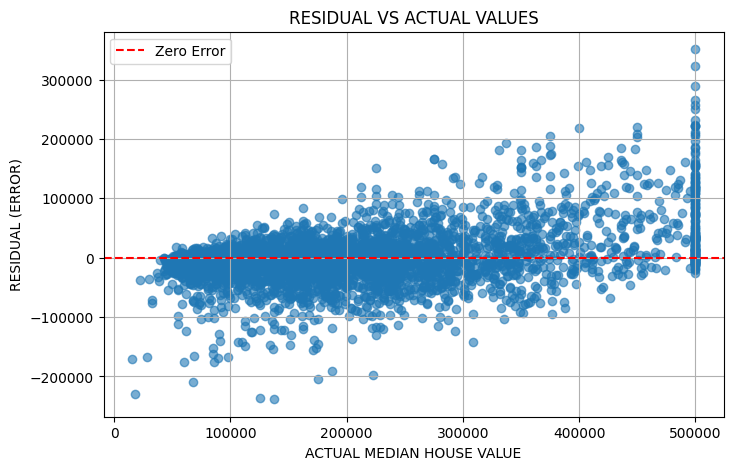

In [ ]:
# Residual Analysis - Checking error distribution and patterns

# 1. Calculate residuals (actual - predicted)
residuals = y_test - y_pred

# 2. Show basic statistics of residuals
print("Residual Summary Statistics:")
print(residuals.describe().round(2))

# 3. Histogram of residuals to check for normality
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("DISTRIBUTION OF RESIDUAL")
plt.xlabel("RESIDUAL (ERROR)")
plt.ylabel("FREQUENCY")
plt.grid(True)
plt.show()

# 4. Residual vs Actual Values Plot
plt.figure(figsize=(8, 5))
plt.scatter(y_test, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error')
plt.title("RESIDUAL VS ACTUAL VALUES")
plt.xlabel("ACTUAL MEDIAN HOUSE VALUE")
plt.ylabel("RESIDUAL (ERROR)")
plt.grid(True)
plt.legend()
plt.show()

The expected or ideal results of an **`Error (Residual) Analysis`** are:

1. Residual distribution --> approaches a bell-shaped (normal) curve and not heavily skewed left or right.

2.  Residual mean value --> close to zero.

3. Residual spread --> no clear pattern in the scatter plot (residuals vs. `y_test`), just random noise.

4. Symmetry --> underprediction and overprediction errors are balanced.

##### **Conclusion of Error (Residual) Analysis**

1. **Residual Distribution**.
- The histogram of residuals shows a bell-shaped curve, resembling a normal distribution, with the peak centered around zero.
- This suggests that the model does not systematically underpredict or overpredict which is a good sign of model neutrality.

2. **Residual vs Actual Value Plot**.
- The scatter plot of residuals vs actual house values displays a fairly random spread above and below the red zero-error line.
- While there is increasing variance at higher house prices, no clear pattern or structure is evident indicating the model's errors are random, not biased.

3. **Residual Summary Statistics**.
- Mean residual: -819.62 (very close to zero which is desirable).
- Median residual (Q2): -4573.95 (reasonably close to zero, suggesting slight but not critical skewness).

- Residual range: From -238,352 to +351,057,indicating some large prediction errors on extreme cases.

- Standard deviation: 46,372.93 which is quite high, but acceptable considering house prices are in the range of hundreds of thousands.

4. **Final Conclusion**.
- The **LightGBM Regressor with Optuna tuning** model exhibits no strong systematic bias, exhibits a residual distribution close to normal, maintains reasonably balanced errors, and demonstrates trustworthy performance for predicting California housing prices.

### B. y_true vs y_pred Visualization

The scatter plot of **actual values (y_test)** VS **predicted values (y_pred)** is a crucial diagnostic tool to evaluate how well the model is performing.

A well-performing model will produce points that cluster around the diagonal line from bottom-left to top-right.

This visualization helps to:
1. Detect whether the model fails on extreme price ranges **(very high or very low)**.

2. Identify systematic bias in predictions **(e.g., always underpredicting or overpredicting)**.

3. Spot **outliers or unusually large errors** in the prediction set.

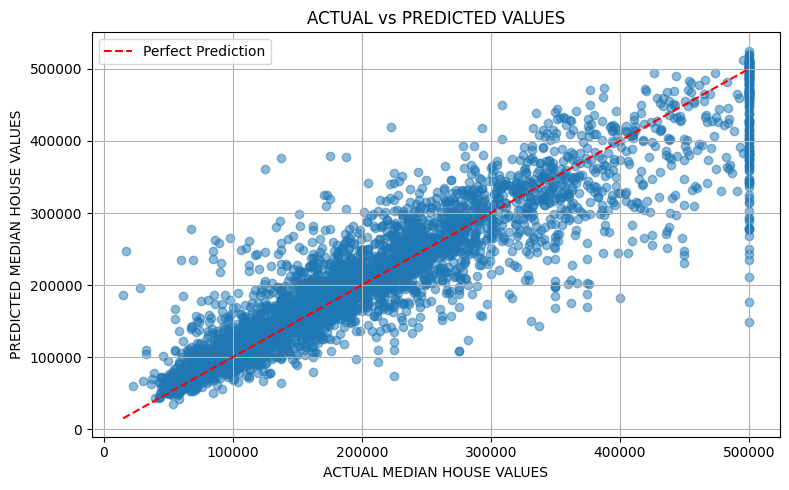

In [ ]:
# Visualizing y_test VS y_pred to assess LightGBM Regressor with Optuna Tuning model performance

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')

plt.xlabel("ACTUAL MEDIAN HOUSE VALUES")
plt.ylabel("PREDICTED MEDIAN HOUSE VALUES")
plt.title("ACTUAL vs PREDICTED VALUES")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Conclusion of y_true vs y_pred Visualization**

From the scatter plot above, I can conclude that:

1. Most of the points lie relatively close to the red dashed line (y = x), indicating that the **LightGBM Regressor with Optuna tuning** model's predictions are fairly accurate for the majority of the test data.

2. The points form a diagonal trend from **bottom left to top right**, suggesting that the model has successfully captured the underlying pattern between actual and predicted house values.

3. However, **there is more variance (scatter) at the higher price range** (above USD 400,000), indicating that the model may be less precise when predicting expensive houses, potentially due to fewer high-value samples in the dataset.

4. There is **no clear sign of overfitting or underfitting**, meaning the model performs reasonably well and generalizes across different value ranges.

## XIV. SAVING THE CHOSEN MODEL FOR FUTURE TEST & USE

In [ ]:
# 1. Save the trained and tuned LightGBM model into a .pkl file
model_filename = 'lightgbm_optuna_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(lightgbm_optuna_model, file)

print(f"Model has been saved successfully as {model_filename}!")

Model has been saved successfully as lightgbm_optuna_model.pkl!


After saving the chosen model as **`lightgbm_optuna_model.pkl`**, now let's give it a try by applying the chosen model into a randomly generated dataset.

In [ ]:
# 2. Reload lightgbm_optuna_model.pkl for future use
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

print("Model has been loaded successfully!")

Model has been loaded successfully!


In [ ]:
# 3. Test the model on randomly generated input data (simulated new data)

# 3a. Use a similar distribution as X_test for valid test simulation
random_data = np.random.normal(loc=X_test.mean(), scale=X_test.std(), size=(5, X_test.shape[1]))

# 3b. Predict house prices from the synthetic dataset
predictions = loaded_model.predict(random_data)

# 3c. Display prediction results
print("Predictions on Random Dataset:")
for i, pred in enumerate(predictions, 1):
    print(f"For house #{i}: the estimated median value is ${pred:,.2f}")

Predictions on Random Dataset:
For house #1: the estimated median value is $299,040.10
For house #2: the estimated median value is $293,989.83
For house #3: the estimated median value is $296,962.09
For house #4: the estimated median value is $270,694.34
For house #5: the estimated median value is $297,757.09


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## XV. KEY STEPS TAKEN

1. **Data Cleaning & Preprocessing**.
- Handled missing values using median imputation.
- Detected and mitigated outliers using Winsorization method.
- Encoded categorical variables using One-Hot Encoding.

2. **Feature Engineering**.
- Created a new feature/variable/column, which is `bedroom_ratio = total_bedrooms / total_rooms` for additional insight.

3. **Exploratory Data Analysis (EDA)**.
- Conducted descriptive statistics and correlation analysis to identify key variables.

4. **Model Building & Evaluation**.
- Trained four regression models, such as `Ridge Linear`, `LightGBM`, `Random Forest`, and `XGBoost`.
- Tuned hyperparameters using `Optuna` for each model.
- Evaluated models using `MAE`, `MSE`, `RMSE`, and `R² scores`.
- Identified `LightGBM + Optuna tuning (lightgbm_optuna_model)` as the best-performing model.

5. **Model Interpretation**.
- Performed `SHAP value analysis` to explain model predictions.
- Conducted `residual analysis` and `y_true vs y_pred visualization` for performance sanity checks.

6. **Final Output**.
- Saved the best model and validated it on a randomly generated dataset.

## XVI. EXECUTIVE SUMMARY

This project aimed to predict `California's housing prices` using structured housing dataset. Through systematic `data cleaning`, `feature engineering`, and `model experimentations`, `LightGBM with Optuna tuning` was identified as the best-performing model.

It demonstrated robust prediction ability with balanced error distribution and explainable outputs via SHAP analysis.

The model's performance was evaluated with residual analysis and y_true vs y_pred visualization.Its performance was also tested on a randomly created housing dataset.

This end-to-end machine learning pipeline provides a solid baseline for real-estate price prediction.